In [1]:
#Paramètres Python et Pandas

import pandas as pd 
import numpy as np
import missingno as msno
from datetime import datetime


In [2]:
# Visualisation des graphiques 

import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm, shapiro

In [3]:
# Calculs statistiques
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model


In [4]:
# Pévisions des modèles saisonniers
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from functions import*

In [5]:
# Modèles SARIMAX
from statsmodels.tsa.statespace.sarimax import*
from statsmodels.stats.diagnostic import acorr_ljungbox

In [6]:
conso_mensuelle = pd.read_excel(r"C:\Users\Utilisateur\projet 9\conso_mensuelle.xlsx", parse_dates=[0])
conso_mensuelle

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,2012-01-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,...,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
1,2012-02-01,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,...,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
2,2012-03-01,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,...,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0
3,2012-04-01,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,...,405,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0
4,2012-05-01,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,...,469,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,2021-06-01,Données consolidées,Occitanie,2228,897.0,0,724.0,0,0,724,...,39,2567,-474.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1334,2021-06-01,Données consolidées,Normandie,6498,6215.0,142,0.0,19,123,10,...,58,1877,4620.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1335,2021-06-01,Données consolidées,Hauts-de-France,3271,2347.0,465,0.0,0,465,1,...,77,3456,-185.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1336,2021-06-01,Données consolidées,PACA,1697,57.0,173,-1.0,16,158,1217,...,57,2940,-1249.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
conso_mensuelle.columns

Index(['Mois', 'Qualité', 'Territoire', 'Production totale',
       'Production nucléaire', 'Production thermique totale',
       'Production thermique charbon', 'Production thermique fioul',
       'Production thermique gaz', 'Production hydraulique',
       'Production éolien', 'Production solaire', 'Production bioénergies',
       'Consommation totale', 'Solde exportateur', 'Echanges export',
       'Echanges import', 'Echanges avec le Royaume-Uni',
       'Echanges avec l'Espagne', 'Echanges avec l'Italie',
       'Echanges avec la Suisse', 'Echanges avec l'Allemagne et la Belgique'],
      dtype='object')

In [8]:
# Restriction du jeu de donnée
conso_france = conso_mensuelle[['Territoire','Mois','Consommation totale']]
conso_france

,Territoire,Mois,Consommation totale
0,France,2012-01-01,51086
1,France,2012-02-01,54476
2,France,2012-03-01,43156
3,France,2012-04-01,40176
4,France,2012-05-01,35257
...,...,...,...
1333,Occitanie,2021-06-01,2567
1334,Normandie,2021-06-01,1877
1335,Hauts-de-France,2021-06-01,3456
1336,PACA,2021-06-01,2940


In [9]:
conso_france.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Territoire           1338 non-null   object        
 1   Mois                 1338 non-null   datetime64[ns]
 2   Consommation totale  1338 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 31.5+ KB


# Mision 0 : Traitement du jeu de donnée 

## La colonne territoire devient France

In [10]:
# Regroupe territoire égale France
Consommation = conso_france.loc[conso_france["Territoire"] == "France"]
Consommation = Consommation.rename(columns = {"Consommation totale": "Conso_total_observe"})
Consommation.head()

,Territoire,Mois,Conso_total_observe
0,France,2012-01-01,51086
1,France,2012-02-01,54476
2,France,2012-03-01,43156
3,France,2012-04-01,40176
4,France,2012-05-01,35257


## Conversion de la date 

In [11]:
#Tout d'abord on convertit la date en format pouvant être modifié avec la fonction to_datetime de pandas.
Consommation["Mois"] = pd.to_datetime(Consommation["Mois"])
Consommation

,Territoire,Mois,Conso_total_observe
0,France,2012-01-01,51086
1,France,2012-02-01,54476
2,France,2012-03-01,43156
3,France,2012-04-01,40176
4,France,2012-05-01,35257
...,...,...,...
1279,France,2021-02-01,43024
1292,France,2021-03-01,43913
1305,France,2021-04-01,37747
1318,France,2021-05-01,35007


In [12]:
Consommation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 0 to 1331
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Territoire           114 non-null    object        
 1   Mois                 114 non-null    datetime64[ns]
 2   Conso_total_observe  114 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 3.6+ KB


## Visualisation des valeurs manquantes 

<AxesSubplot:>

<Figure size 432x432 with 0 Axes>

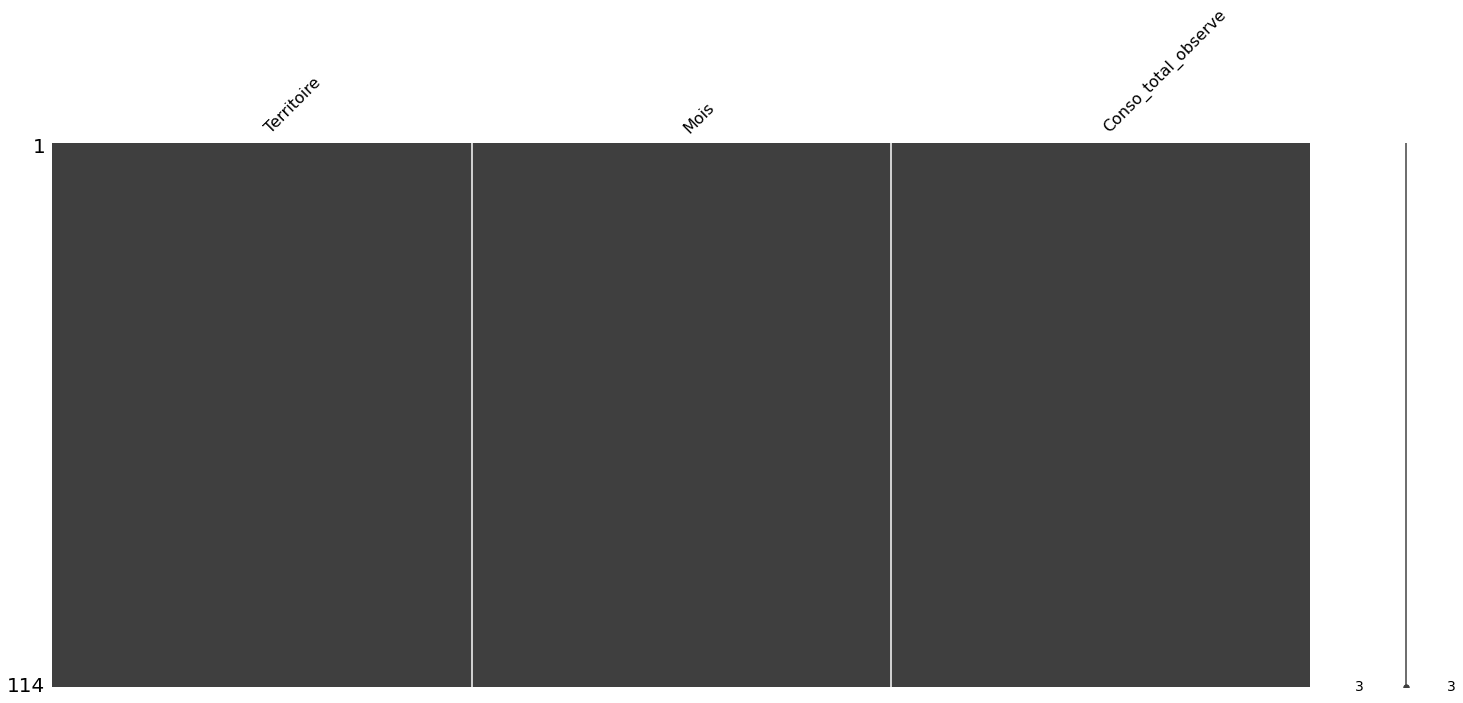

In [13]:
# On untilise missingno
plt.figure(figsize = (6,6))
msno.matrix(Consommation)

## Recherche des valeurs aberrantes 

In [14]:
aberrantes = Consommation.groupby(by = ["Mois"]).nunique()
aberrantes

,Territoire,Conso_total_observe
Mois,,
2012-01-01,1,1
2012-02-01,1,1
2012-03-01,1,1
2012-04-01,1,1
2012-05-01,1,1
...,...,...
2021-02-01,1,1
2021-03-01,1,1
2021-04-01,1,1


In [15]:
aberrantes.Territoire.unique()

array([1], dtype=int64)

## Recherche des doublons

In [16]:
Consommation.drop_duplicates()

,Territoire,Mois,Conso_total_observe
0,France,2012-01-01,51086
1,France,2012-02-01,54476
2,France,2012-03-01,43156
3,France,2012-04-01,40176
4,France,2012-05-01,35257
...,...,...,...
1279,France,2021-02-01,43024
1292,France,2021-03-01,43913
1305,France,2021-04-01,37747
1318,France,2021-05-01,35007


## Résumé du dataset 

In [17]:
Consommation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 0 to 1331
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Territoire           114 non-null    object        
 1   Mois                 114 non-null    datetime64[ns]
 2   Conso_total_observe  114 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 3.6+ KB


On a un jeu de données complet pour chaque variable avec 114 lignes et 3 colonnes, la date est bien au format date 

## Visualisation de la consommation

In [18]:
#Restriction du jeu de donnée
Consommation_mensuelle = Consommation[["Mois", "Conso_total_observe"]]
Consommation_mensuelle

,Mois,Conso_total_observe
0,2012-01-01,51086
1,2012-02-01,54476
2,2012-03-01,43156
3,2012-04-01,40176
4,2012-05-01,35257
...,...,...
1279,2021-02-01,43024
1292,2021-03-01,43913
1305,2021-04-01,37747
1318,2021-05-01,35007


In [19]:
Consommation_mensuelle.tail()

,Mois,Conso_total_observe
1279,2021-02-01,43024
1292,2021-03-01,43913
1305,2021-04-01,37747
1318,2021-05-01,35007
1331,2021-06-01,32032


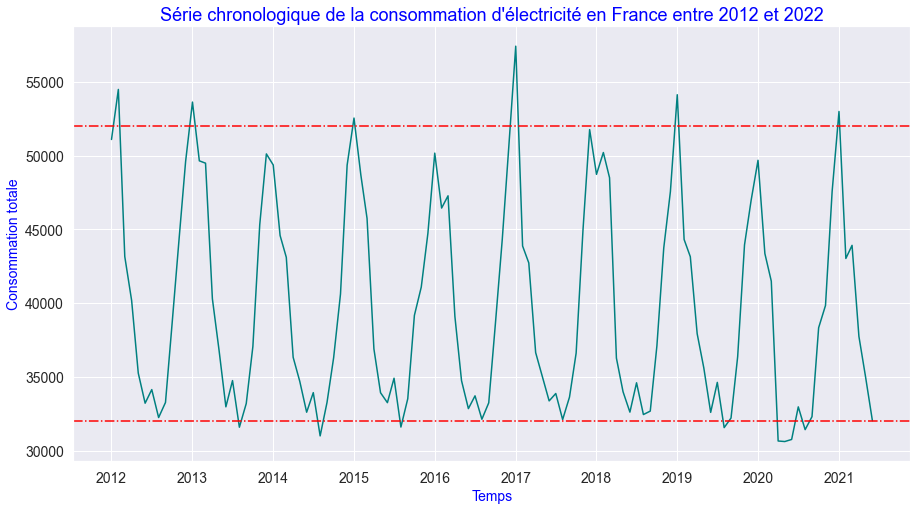

In [20]:
sns.set(style = "darkgrid")
plt.figure(figsize = (15,8))

# Variables de la figure
x = Consommation_mensuelle["Mois"]
y = Consommation_mensuelle["Conso_total_observe"]


# Métadonnées
plt.title("Série chronologique de la consommation d'électricité en France entre 2012 et 2022", fontsize = 18, color = "blue")
plt.ylabel("Consommation totale", fontsize = 14, color = "blue")
plt.xlabel("Temps", fontsize = 14, color = "blue")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# Sauvegarder la figure 
plt.savefig("Conso_mensuelle.png")
plt.plot(x,y, color = "teal")
plt.axhline(52000, linestyle = "dashdot", color = "red")
plt.axhline(32000, linestyle = "dashdot", color = "red")

# Mission 1

## Dégre Jour Unifié Chauffage (DJU)

In [21]:
chauffage_mensuel = pd.read_excel(r"C:\Users\Utilisateur\projet 9\DJU_chauffage.xlsx", skiprows=11)
chauffage_mensuel = chauffage_mensuel.rename(columns = {"Unnamed: 0" :  "Annee"})
chauffage_mensuel

,Annee,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
0,2021,396.7,302.8,271.0,228.3,138.3,1.4,0.0,0.0,0.0,0.0,0.0,0.0,1338.2
1,2020,339.0,249.6,268.6,81.4,65.7,20.6,0.9,4.5,34.3,157.5,227.2,336.8,1785.9
2,2019,404.9,268.3,233.1,168.5,117.9,24.4,0.0,1.7,26.7,133.7,282.6,327.3,1989.0
3,2018,303.4,432.6,314.3,119.7,55.9,8.1,0.0,3.3,34.3,122.4,282.5,325.9,2002.2
4,2017,467.9,278.4,206.1,182.6,75.0,9.4,1.0,6.8,62.6,99.4,282.6,369.0,2040.6
5,2016,364.4,321.6,321.1,212.1,88.1,27.5,5.7,3.2,11.7,176.0,285.6,390.8,2207.3
6,2015,392.0,365.7,275.5,141.1,91.5,15.8,6.9,6.1,71.9,176.9,195.0,248.1,1986.2
7,2014,324.4,281.9,223.9,135.5,100.2,19.1,8.3,19.3,16.0,92.3,222.6,368.2,1811.5
8,2013,429.2,402.2,376.6,209.5,158.4,43.6,0.6,5.0,41.5,105.0,303.9,349.5,2424.8
9,2012,336.0,435.9,201.9,230.3,83.3,35.0,12.4,2.4,58.0,154.6,296.2,345.9,2191.5


In [22]:
# Renommer les colonnes  
# Ici les mois on les prend en tant que string

chauffage_mensuel = chauffage_mensuel.rename(columns ={"JAN":"1",
                                                   "FÉV" : "2",
                                                   "MAR" : "3",
                                                   "AVR" : "4",
                                                   "MAI" : "5",
                                                   "JUN" :"6",
                                                   "JUI" : "7",
                                                   "AOÛ" : "8",
                                                   "SEP" : "9",
                                                   "OCT" : "10",
                                                   "NOV" : "11",
                                                   "DÉC" : "12"})

# On supprime la colonne total
#chauffage_mensuel = chauffage_mensuel.drop(columns = ["Total"], axis = 1)
chauffage_mensuel

,Annee,1,2,3,4,5,6,7,8,9,10,11,12,Total
0,2021,396.7,302.8,271.0,228.3,138.3,1.4,0.0,0.0,0.0,0.0,0.0,0.0,1338.2
1,2020,339.0,249.6,268.6,81.4,65.7,20.6,0.9,4.5,34.3,157.5,227.2,336.8,1785.9
2,2019,404.9,268.3,233.1,168.5,117.9,24.4,0.0,1.7,26.7,133.7,282.6,327.3,1989.0
3,2018,303.4,432.6,314.3,119.7,55.9,8.1,0.0,3.3,34.3,122.4,282.5,325.9,2002.2
4,2017,467.9,278.4,206.1,182.6,75.0,9.4,1.0,6.8,62.6,99.4,282.6,369.0,2040.6
5,2016,364.4,321.6,321.1,212.1,88.1,27.5,5.7,3.2,11.7,176.0,285.6,390.8,2207.3
6,2015,392.0,365.7,275.5,141.1,91.5,15.8,6.9,6.1,71.9,176.9,195.0,248.1,1986.2
7,2014,324.4,281.9,223.9,135.5,100.2,19.1,8.3,19.3,16.0,92.3,222.6,368.2,1811.5
8,2013,429.2,402.2,376.6,209.5,158.4,43.6,0.6,5.0,41.5,105.0,303.9,349.5,2424.8
9,2012,336.0,435.9,201.9,230.3,83.3,35.0,12.4,2.4,58.0,154.6,296.2,345.9,2191.5


In [23]:
# Nous allons dépivoté les colonnes mois afin de créer une seule colonne mois
#https://pandas.pydata.org/docs/reference/api/pandas.melt.html


chauffage_mensuel = pd.melt(chauffage_mensuel, id_vars=['Annee'], 
                            value_vars = ["1","2","3","4","5","6","7","8","9","10","11","12"] ,
                            var_name = 'Mois', value_name = 'DJU')
                                                    


chauffage_mensuel

,Annee,Mois,DJU
0,2021,1,396.7
1,2020,1,339.0
2,2019,1,404.9
3,2018,1,303.4
4,2017,1,467.9
...,...,...,...
115,2016,12,390.8
116,2015,12,248.1
117,2014,12,368.2
118,2013,12,349.5


In [24]:
# https://qastack.fr/programming/17978092/combine-date-and-time-columns-using-python-pandas

# On converti  les colonnes en même types ici en str pour utiliser la fonction to_datetime:
# NB: to_datetime ne fonctionne qu'avec des variables de même type

chauffage_mensuel["date"] = pd.to_datetime(chauffage_mensuel.Annee.astype(str)+' '
                                           +chauffage_mensuel.Mois.astype(str))
                                           
chauffage_mensuel

,Annee,Mois,DJU,date
0,2021,1,396.7,2021-01-01
1,2020,1,339.0,2020-01-01
2,2019,1,404.9,2019-01-01
3,2018,1,303.4,2018-01-01
4,2017,1,467.9,2017-01-01
...,...,...,...,...
115,2016,12,390.8,2016-12-01
116,2015,12,248.1,2015-12-01
117,2014,12,368.2,2014-12-01
118,2013,12,349.5,2013-12-01


Ici la date est au format datetime

In [25]:
#On récupère les variables qui nous intérèsse 
chauffage_ms = chauffage_mensuel[["date", "DJU"]]
chauffage_ms = chauffage_ms.rename(columns = {"date" : "Mois"})
chauffage_ms =  chauffage_ms.sort_values(by = "Mois")
chauffage_ms

,Mois,DJU
9,2012-01-01,336.0
19,2012-02-01,435.9
29,2012-03-01,201.9
39,2012-04-01,230.3
49,2012-05-01,83.3
...,...,...
70,2021-08-01,0.0
80,2021-09-01,0.0
90,2021-10-01,0.0
100,2021-11-01,0.0


In [26]:
chauffage_ms.tail(7)

,Mois,DJU
50,2021-06-01,1.4
60,2021-07-01,0.0
70,2021-08-01,0.0
80,2021-09-01,0.0
90,2021-10-01,0.0
100,2021-11-01,0.0
110,2021-12-01,0.0


In [27]:
chauffage_ms.to_excel("chauffage_ms.xlsx", index = False)

In [28]:
chauffage_mois = pd.read_excel(r"C:\Users\Utilisateur\projet 9\chauffage_ms.xlsx")
chauffage_mois.tail()

,Mois,DJU
115,2021-08-01,0.0
116,2021-09-01,0.0
117,2021-10-01,0.0
118,2021-11-01,0.0
119,2021-12-01,0.0


<AxesSubplot:>

<Figure size 216x216 with 0 Axes>

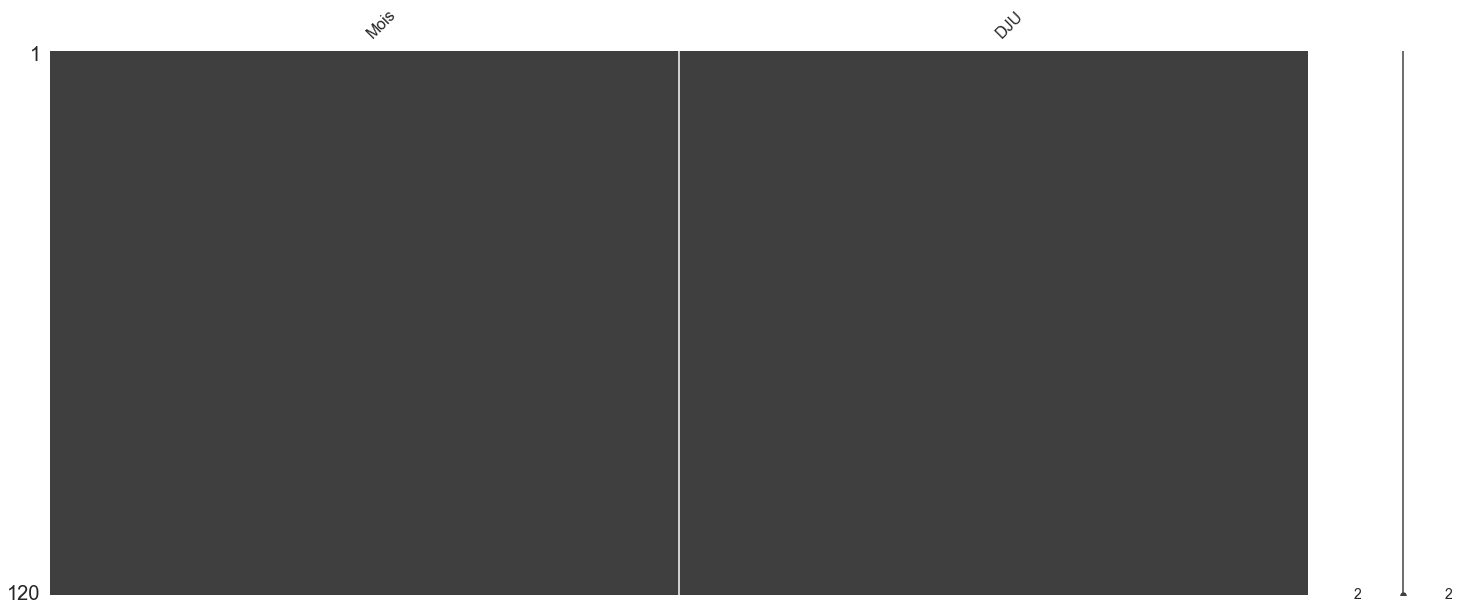

In [29]:
# On untilise missingno
plt.figure(figsize = (3,3))
msno.matrix(chauffage_mois)

Nous allons visualiser l'effet  du chauffage sur la consommation d'électricité pour cela nous allons supperposer les courbes chauffage et consommation électrique 

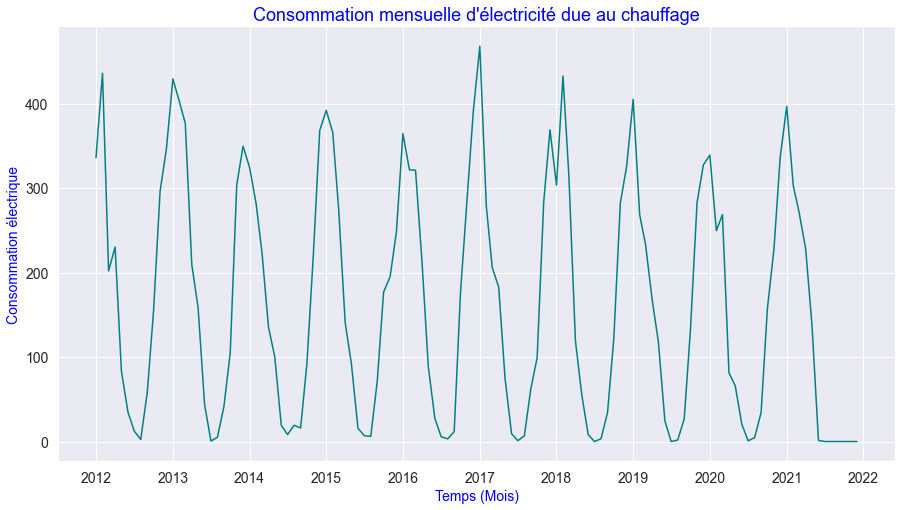

In [30]:
sns.set(style = "darkgrid")
plt.figure(figsize = (15,8))

# Variables de la figure
x = chauffage_mois["Mois"]
y = chauffage_mois["DJU"]


# Métadonnées
plt.title("Consommation mensuelle d'électricité due au chauffage", fontsize = 18, color = "blue")
plt.ylabel("Consommation électrique", fontsize = 14, color = "blue")
plt.xlabel("Temps (Mois)", fontsize = 14, color = "blue")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)



# Sauvegarder la figure 
plt.savefig("Conso_mensuelle_dju.png")
plt.plot(x,y, color = "teal")

## Effet du chauffage sur la consommation électrique

In [31]:
electricite_chauffage = pd.merge(Consommation_mensuelle, chauffage_mois, right_on = "Mois", left_on = "Mois")
electricite_chauffage.set_index("Mois", inplace = True)
electricite_chauffage = electricite_chauffage.sort_values(by = "Mois")
electricite_chauffage

,Conso_total_observe,DJU
Mois,,
2012-01-01,51086,336.0
2012-02-01,54476,435.9
2012-03-01,43156,201.9
2012-04-01,40176,230.3
2012-05-01,35257,83.3
...,...,...
2021-02-01,43024,302.8
2021-03-01,43913,271.0
2021-04-01,37747,228.3


In [32]:
electricite_chauffage.tail(7)

,Conso_total_observe,DJU
Mois,,
2020-12-01,47565,336.8
2021-01-01,52983,396.7
2021-02-01,43024,302.8
2021-03-01,43913,271.0
2021-04-01,37747,228.3
2021-05-01,35007,138.3
2021-06-01,32032,1.4


<AxesSubplot:>

<Figure size 216x216 with 0 Axes>

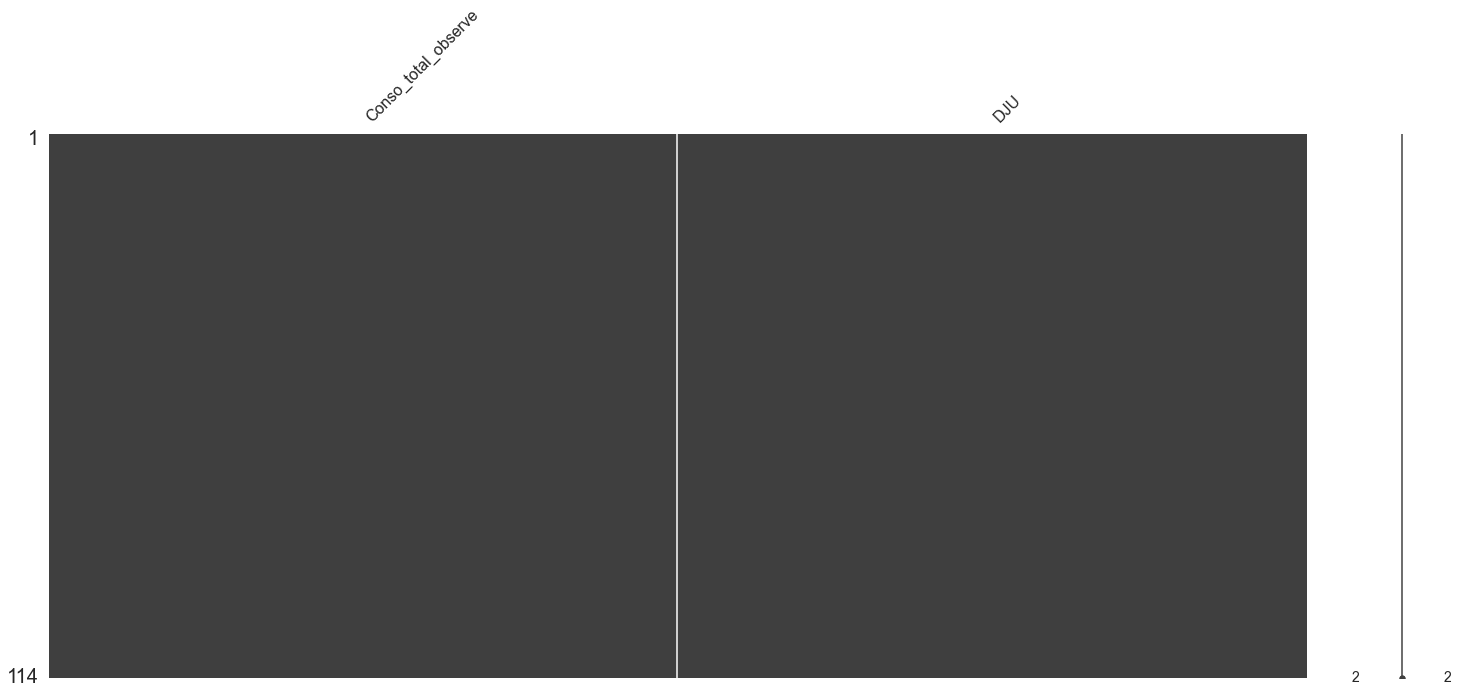

In [33]:
# On untilise missingno
plt.figure(figsize = (3,3))
msno.matrix(electricite_chauffage)

In [34]:
#Pour ajouter un deuxième axe dans un graph
# https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend

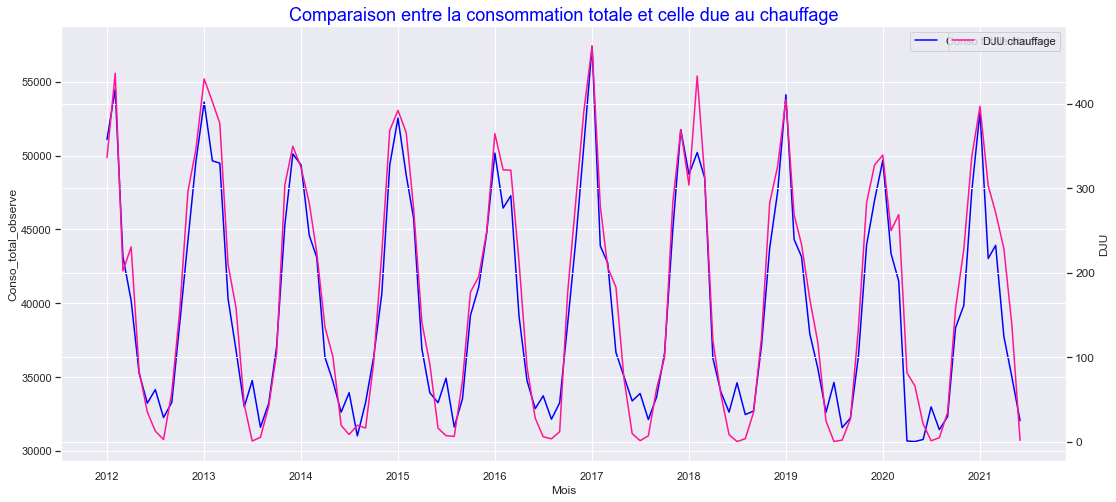

In [35]:
plt.figure(figsize=(18,8))

ax1 = sns.lineplot(data = electricite_chauffage,   
                      x = electricite_chauffage.index, 
                      y = "Conso_total_observe", 
                  color = "blue",
                  label = "Conso totale observée")

ax2 = plt.twinx() # permet de considérer l'axe des X comme étant commun


ax2 = sns.lineplot(data = electricite_chauffage,
                      x = electricite_chauffage.index, 
                       y= "DJU", 
                   color="deeppink", 
                     ax = ax2, 
                   label="DJU chauffage")
                                               


# Métadonnées
plt.title("Comparaison entre la consommation totale et celle due au chauffage", fontsize = 18, color = "blue")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 12, rotation =45)
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

## Corrigez les données de consommation avec la régréssion linéaire

In [36]:
import statsmodels.formula.api as smf


### Entraînement du modèle de la régression linéaire 

### Visualisez de la droite de régression

In [37]:
from sklearn import linear_model


[]

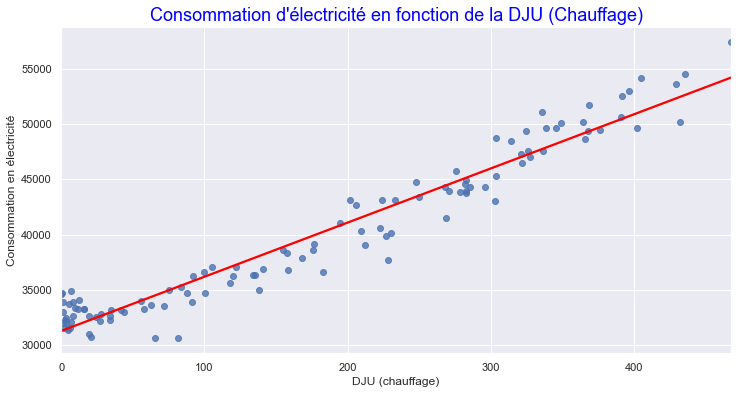

In [38]:
# Paramètres  de la figure
sns.set(style = "darkgrid")
plt.figure(figsize = (12,6))

# Données pour tracer la figure
ax = sns.regplot(x = "DJU",
                 y = "Conso_total_observe", 
                 data = electricite_chauffage,
                 ci = None, 
                 line_kws = {"color" : "red"} )
# Métadonnées 
ax.set(xlabel = "DJU (chauffage)",
       ylabel = "Consommation en électricité")
plt.title("Consommation d'électricité en fonction de la DJU (Chauffage)", 
          fontsize = 18,
          color = "blue")

# Sauvegarde la la figure 
plt.savefig("droite_regression_conso.png")

plt.plot()

#### Calcul de la pente et de l'ordonnée à l'origine

In [39]:
# Création des données d'entraînement 
X = np.matrix([np.ones(electricite_chauffage.shape[0]), electricite_chauffage['DJU']]).T
X[:10]

matrix([[  1. , 336. ],
        [  1. , 435.9],
        [  1. , 201.9],
        [  1. , 230.3],
        [  1. ,  83.3],
        [  1. ,  35. ],
        [  1. ,  12.4],
        [  1. ,   2.4],
        [  1. ,  58. ],
        [  1. , 154.6]])

In [40]:
Y = np.matrix(electricite_chauffage['Conso_total_observe']).T
Y[:10]

matrix([[51086],
        [54476],
        [43156],
        [40176],
        [35257],
        [33219],
        [34141],
        [32247],
        [33269],
        [38628]], dtype=int64)

In [41]:
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
theta

matrix([[31309.39597599],
        [   48.89118488]])

### Réalisez une régression linéaire simple

In [42]:
reg_simp = smf.ols('Conso_total_observe ~ DJU', data = electricite_chauffage).fit()
print(reg_simp.summary())

                             OLS Regression Results                            
Dep. Variable:     Conso_total_observe   R-squared:                       0.940
Model:                             OLS   Adj. R-squared:                  0.940
Method:                  Least Squares   F-statistic:                     1766.
Date:                 Mon, 07 Feb 2022   Prob (F-statistic):           2.07e-70
Time:                         16:41:35   Log-Likelihood:                -1011.1
No. Observations:                  114   AIC:                             2026.
Df Residuals:                      112   BIC:                             2032.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.131e+04    259.207    120.78

In [43]:
# On détermine les paramètre a et b  avec la fonction params
#a = Intercept   coefficient directeur de la droite 
#b = DJU   pente     
a, b = reg_simp.params
print( a, b)

31309.395975992033 48.891184882400594


### Vérification de la performance du modèle de régression linéaire

#### On crée la variable contenant les valeurs ajustées

In [44]:
# On crée une variable contenant les données ajustées
#Conso_total_observe_ajuste = Conso_ajuste_reg_lineaire
electricite_chauffage["Conso_ajuste_reg_lineaire"] = reg_simp.predict() # On ajoute au data la colonne ajustée
electricite_chauffage

,Conso_total_observe,DJU,Conso_ajuste_reg_lineaire
Mois,,,
2012-01-01,51086,336.0,47736.834096
2012-02-01,54476,435.9,52621.063466
2012-03-01,43156,201.9,41180.526204
2012-04-01,40176,230.3,42569.035854
2012-05-01,35257,83.3,35382.031677
...,...,...,...
2021-02-01,43024,302.8,46113.646758
2021-03-01,43913,271.0,44558.907079
2021-04-01,37747,228.3,42471.253485


#### Visualisation de la droite de régression des valeurs ajustée

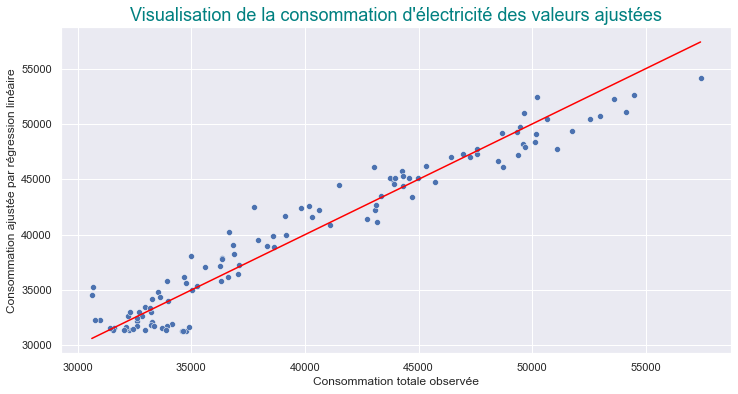

In [45]:
# On sélectionne l'étendue de notre figure
x_plot = [electricite_chauffage["Conso_total_observe"].min(), electricite_chauffage["Conso_total_observe"].max()]

# Paramètres de la figure
sns.set(style = "darkgrid")
plt.figure(figsize = (12,6))

# Données de la figure

ax = sns.scatterplot(x = "Conso_total_observe", 
                     y = "Conso_ajuste_reg_lineaire",
                  data = electricite_chauffage)

# Métadonnées
ax.set(xlabel = "Consommation totale observée", 
       ylabel = "Consommation ajustée par régression linéaire")

plt.title("Visualisation de la consommation d'électricité des valeurs ajustées",
          fontsize = 18, 
          color = "teal")

plt.plot (x_plot, x_plot, color = "red")

# Sauvegarder la figure 
plt.savefig("Conso_mensuelle_ajustee.png")
plt.show()

#

#### Représenter les résidus du modèle epsilon 

##### Droite d'Henry

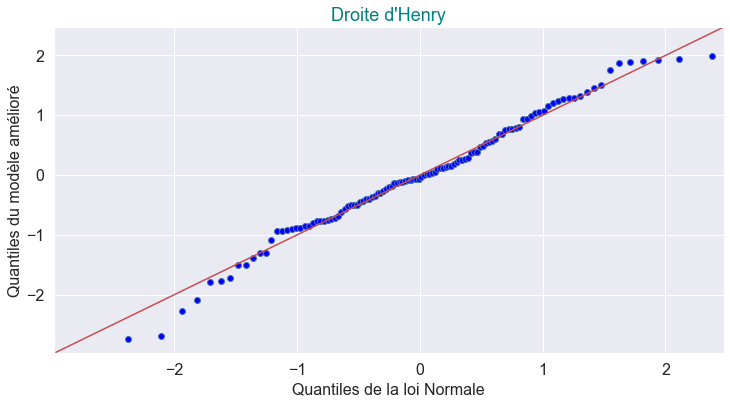

In [46]:
# Droite de Henry

# paramètre de la figure
fig, ax  = plt.subplots(figsize=(12,6))

# Données de la figure
sm.qqplot(reg_simp.resid,
          line='45', 
          fit=True, 
          ax = ax)

# Métadonnées
plt.ylabel("Quantiles du modèle amélioré", fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Quantiles de la loi Normale", fontsize=16)
plt.xticks(fontsize=16)
plt.title("Droite d'Henry", fontsize = 18, color = "teal")


plt.savefig('Droite_henry.png')
plt.show()

##### Courbe de distribution

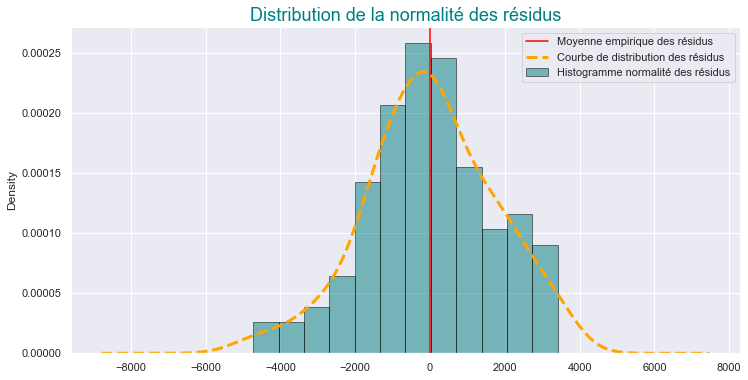

In [47]:
# Paramètres de la figure 
fig = plt.figure(figsize=(12,6))

#Paramètres de la figure

#ax = sns.distplot(reg_simp.resid, fit=stats.norm) # paramètre obsolètte
# Histogramme
reg_simp.resid.plot(kind = 'hist',
                    bins = 12, 
                 density = True, 
                   alpha = 0.5, 
               edgecolor = 'black',
                   color = 'teal', 
                   label = "Histogramme normalité des résidus")

# Ajout de la moyenne empirique sur l'histogramme
plt.axvline((np.mean(reg_simp.resid)), 
            color = 'red', 
            label = 'Moyenne empirique des résidus')

# Ajout de la courbe de distribution
reg_simp.resid.plot(kind ='kde', 
                   color = 'orange', 
                   label = 'Courbe de distribution des résidus',
               linestyle = 'dashed', lw = 3)

# Métadonnées

plt.title("Distribution de la normalité des résidus", fontsize=18, color = "teal")

plt.savefig('Normalité des résidus.png')

plt.legend()

plt.show()

##### Test de Shapiro-Wilk

Hypothèse nulle : les données proviennent de la distribution normale; ie pvalue > 5%

In [48]:
w, pvalue = stats.shapiro(reg_simp.resid)
print(w, pvalue)

0.9853870272636414 0.25306108593940735


In [49]:
# Calcul de la consommation ajustée par regression linéaire
#conso_sans_chauffage = Conso_ajustee
electricite_chauffage["conso_ajustee"] = electricite_chauffage["Conso_total_observe"] - b * electricite_chauffage["DJU"]
electricite_chauffage

,Conso_total_observe,DJU,Conso_ajuste_reg_lineaire,conso_ajustee
Mois,,,,
2012-01-01,51086,336.0,47736.834096,34658.561880
2012-02-01,54476,435.9,52621.063466,33164.332510
2012-03-01,43156,201.9,41180.526204,33284.869772
2012-04-01,40176,230.3,42569.035854,28916.360122
2012-05-01,35257,83.3,35382.031677,31184.364299
...,...,...,...,...
2021-02-01,43024,302.8,46113.646758,28219.749218
2021-03-01,43913,271.0,44558.907079,30663.488897
2021-04-01,37747,228.3,42471.253485,26585.142491


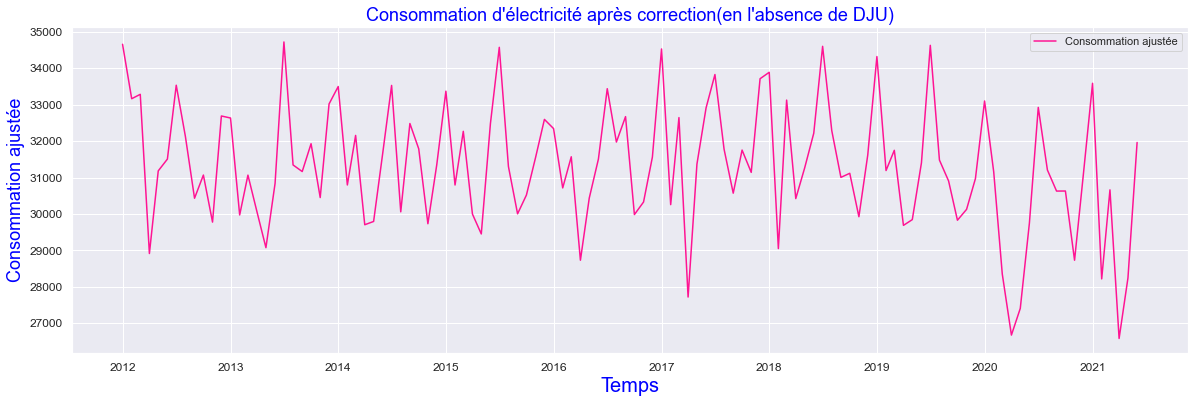

In [50]:
# Figure de la consommation électrique ajustée 
sns.set(style = "darkgrid")
plt.figure(figsize = (20,6))

# Variables de la figure

x2 = electricite_chauffage.index
y2 = electricite_chauffage["conso_ajustee"]


plt.plot(x2, y2, color = "deeppink", label = "Consommation ajustée")

# Métadonnées
plt.title("Consommation d'électricité après correction(en l'absence de DJU)", fontsize = 18, color = "blue")
plt.ylabel("Consommation ajustée", fontsize = 18, color = "blue")
plt.xlabel("Temps", fontsize = 20, color = "blue")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Sauvegarder la figure 
#plt.savefig("Conso_mensuelle.png")


plt.legend()

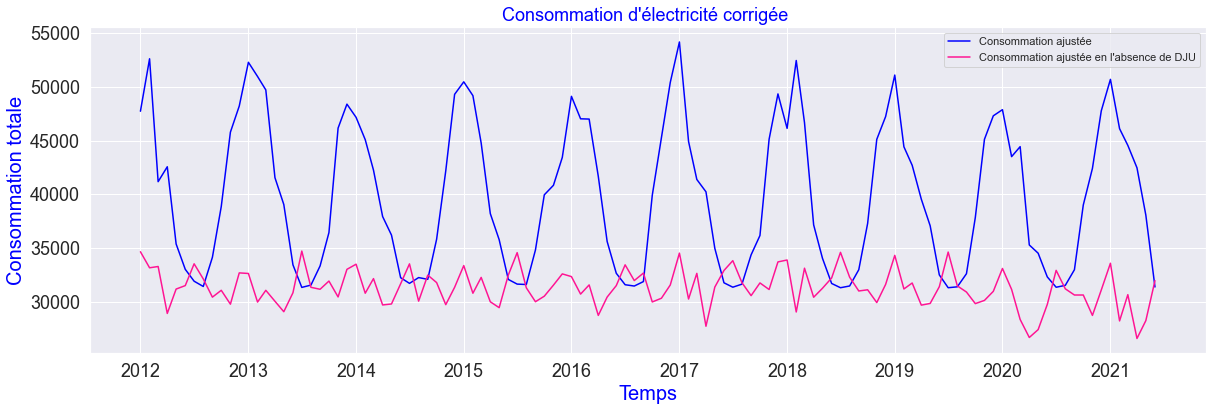

In [51]:
sns.set(style = "darkgrid")
plt.figure(figsize = (20,6))

# Variables de la figure
x1 = electricite_chauffage.index
y1 = electricite_chauffage["Conso_ajuste_reg_lineaire"]
x2 = electricite_chauffage.index
y2 = electricite_chauffage["conso_ajustee"]

plt.plot(x1, y1, color = "blue", label = "Consommation ajustée")

plt.plot(x2, y2, color = "deeppink", label = "Consommation ajustée en l'absence de DJU")

# Métadonnées
plt.title("Consommation d'électricité corrigée ", fontsize = 18, color = "blue")
plt.ylabel("Consommation totale", fontsize = 20, color = "blue")
plt.xlabel("Temps", fontsize = 20, color = "blue")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Sauvegarder la figure 
#plt.savefig("Conso_mensuelle.png")


plt.legend()

# Mission 2

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose

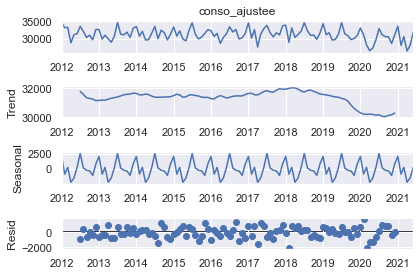

In [53]:
decomp_x = seasonal_decompose( electricite_chauffage["conso_ajustee"],  model='additive')
decomp_x.plot()
plt.show()

In [54]:
#Nous allons créer un dataframe qui contiendra les valeurs de la décomposition saisonière( valeurs désaisonnalisées) 
data_seasonal = pd.DataFrame(decomp_x.seasonal)
data_seasonal

,seasonal
Mois,
2012-01-01,2097.860789
2012-02-01,-862.685202
2012-03-01,265.769402
2012-04-01,-2225.502571
2012-05-01,-1511.254040
...,...
2021-02-01,-862.685202
2021-03-01,265.769402
2021-04-01,-2225.502571


In [55]:
seasonal = pd.merge(electricite_chauffage, data_seasonal, right_on = "Mois", left_on = "Mois")
seasonal = seasonal.rename(columns = {"seasonal": "valeurs_saisonnieres"})
seasonal

,Conso_total_observe,DJU,Conso_ajuste_reg_lineaire,conso_ajustee,valeurs_saisonnieres
Mois,,,,,
2012-01-01,51086,336.0,47736.834096,34658.561880,2097.860789
2012-02-01,54476,435.9,52621.063466,33164.332510,-862.685202
2012-03-01,43156,201.9,41180.526204,33284.869772,265.769402
2012-04-01,40176,230.3,42569.035854,28916.360122,-2225.502571
2012-05-01,35257,83.3,35382.031677,31184.364299,-1511.254040
...,...,...,...,...,...
2021-02-01,43024,302.8,46113.646758,28219.749218,-862.685202
2021-03-01,43913,271.0,44558.907079,30663.488897,265.769402
2021-04-01,37747,228.3,42471.253485,26585.142491,-2225.502571


Données corrigées des variations saisonnières (CVS)

In [56]:
# Nous allons ajouter la colonne valeurs désaisonnalisées qui s'est affranchit de l'impact saisonier

seasonal["cvs"] = seasonal["conso_ajustee"] - seasonal["valeurs_saisonnieres"] 
#seasonal= seasonal.reset_index()
seasonal.head(12)

,Conso_total_observe,DJU,Conso_ajuste_reg_lineaire,conso_ajustee,valeurs_saisonnieres,cvs
Mois,,,,,,
2012-01-01,51086,336.0,47736.834096,34658.561880,2097.860789,32560.701090
2012-02-01,54476,435.9,52621.063466,33164.332510,-862.685202,34027.017711
2012-03-01,43156,201.9,41180.526204,33284.869772,265.769402,33019.100371
2012-04-01,40176,230.3,42569.035854,28916.360122,-2225.502571,31141.862692
2012-05-01,35257,83.3,35382.031677,31184.364299,-1511.254040,32695.618340
2012-06-01,33219,35.0,33020.587447,31507.808529,270.892436,31236.916093
2012-07-01,34141,12.4,31915.646669,33534.749307,2601.019785,30933.729522
2012-08-01,32247,2.4,31426.734820,32129.661156,160.901123,31968.760033
2012-09-01,33269,58.0,34145.084699,30433.311277,-214.642824,30647.954101


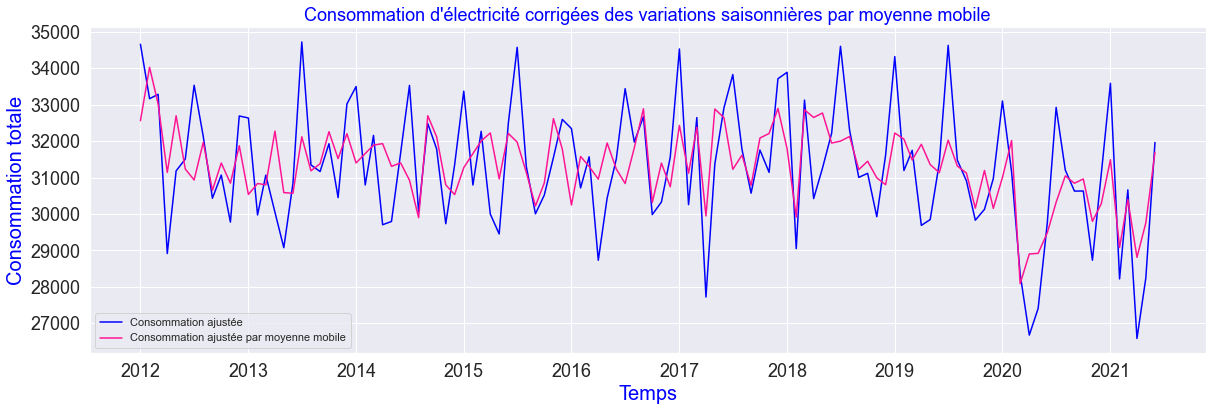

In [57]:
sns.set(style = "darkgrid")
plt.figure(figsize = (20,6))

# Variables de la figure
x1 = seasonal.index
y1 = seasonal["conso_ajustee"]
x2 = seasonal.index
y2 = seasonal["cvs"]

plt.plot(x1, y1, color = "blue", label = "Consommation ajustée")

plt.plot(x2, y2, color = "deeppink", label = "Consommation ajustée par moyenne mobile")

# Métadonnées
plt.title("Consommation d'électricité corrigées des variations saisonnières par moyenne mobile", fontsize = 18, color = "blue")
plt.ylabel("Consommation totale", fontsize = 20, color = "blue")
plt.xlabel("Temps", fontsize = 20, color = "blue")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Sauvegarder la figure 
#plt.savefig("Conso_mensuelle.png")


plt.legend()

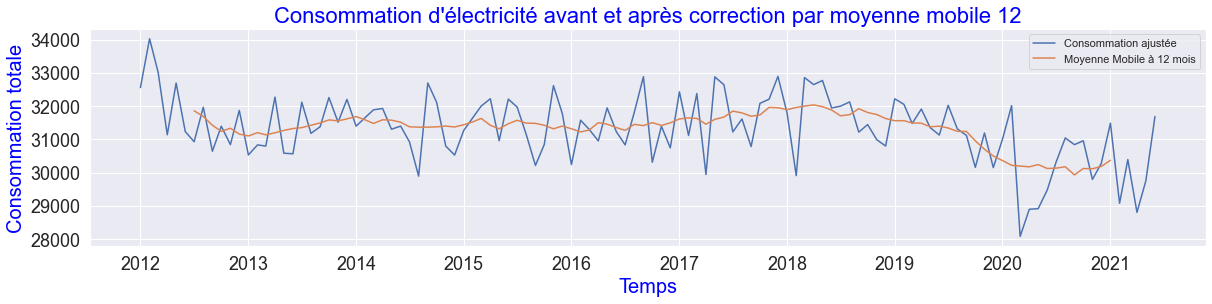

In [58]:
sns.set(style = "darkgrid")
plt.figure(figsize = (20,4))


plt.plot(seasonal['cvs'], label='Consommation ajustée')
plt.plot(seasonal['cvs'].rolling(12, center=True).mean(), label='Moyenne Mobile à 12 mois')

# Variables de la figure

# Métadonnées
plt.title("Consommation d'électricité avant et après correction par moyenne mobile 12", fontsize = 22, color = "blue")
plt.ylabel("Consommation totale", fontsize = 20, color = "blue")
plt.xlabel("Temps", fontsize = 20, color = "blue")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Sauvegarder la figure 
#plt.savefig("Conso_mensuelle.png")


plt.legend()

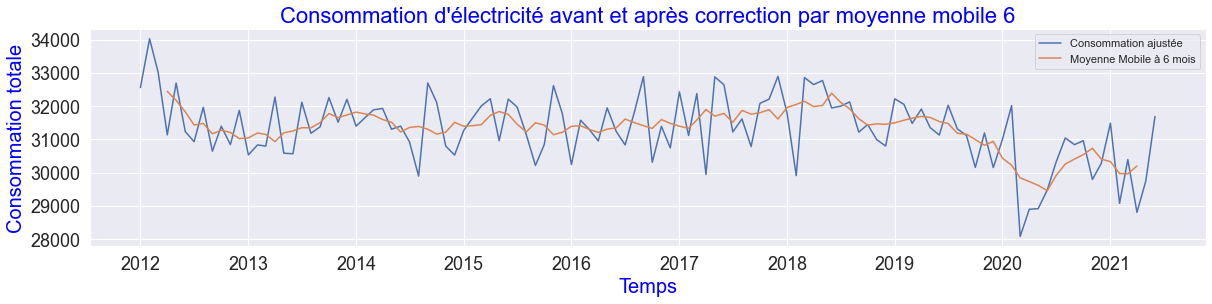

In [59]:
sns.set(style = "darkgrid")
plt.figure(figsize = (20,4))


plt.plot(seasonal['cvs'], label='Consommation ajustée')
plt.plot(seasonal['cvs'].rolling(6, center=True).mean(), label='Moyenne Mobile à 6 mois')

# Variables de la figure

# Métadonnées
plt.title("Consommation d'électricité avant et après correction par moyenne mobile 6", fontsize = 22, color = "blue")
plt.ylabel("Consommation totale", fontsize = 20, color = "blue")
plt.xlabel("Temps", fontsize = 20, color = "blue")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Sauvegarder la figure 
#plt.savefig("Conso_mensuelle.png")


plt.legend()

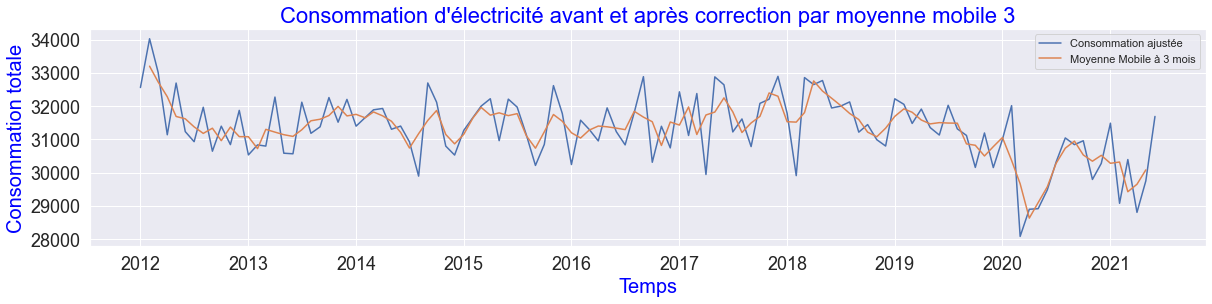

In [60]:
sns.set(style = "darkgrid")
plt.figure(figsize = (20,4))


plt.plot(seasonal['cvs'], label='Consommation ajustée')
plt.plot(seasonal['cvs'].rolling(3, center=True).mean(), label='Moyenne Mobile à 3 mois')

# Variables de la figure

# Métadonnées
plt.title("Consommation d'électricité avant et après correction par moyenne mobile 3", fontsize = 22, color = "blue")
plt.ylabel("Consommation totale", fontsize = 20, color = "blue")
plt.xlabel("Temps", fontsize = 20, color = "blue")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Sauvegarder la figure 
#plt.savefig("Conso_mensuelle.png")


plt.legend()

In [61]:
df_electricite_chauffage = seasonal[["Conso_total_observe", "Conso_ajuste_reg_lineaire",
                                          "conso_ajustee", "cvs"]]
df_electricite_chauffage

,Conso_total_observe,Conso_ajuste_reg_lineaire,conso_ajustee,cvs
Mois,,,,
2012-01-01,51086,47736.834096,34658.561880,32560.701090
2012-02-01,54476,52621.063466,33164.332510,34027.017711
2012-03-01,43156,41180.526204,33284.869772,33019.100371
2012-04-01,40176,42569.035854,28916.360122,31141.862692
2012-05-01,35257,35382.031677,31184.364299,32695.618340
...,...,...,...,...
2021-02-01,43024,46113.646758,28219.749218,29082.434419
2021-03-01,43913,44558.907079,30663.488897,30397.719495
2021-04-01,37747,42471.253485,26585.142491,28810.645062


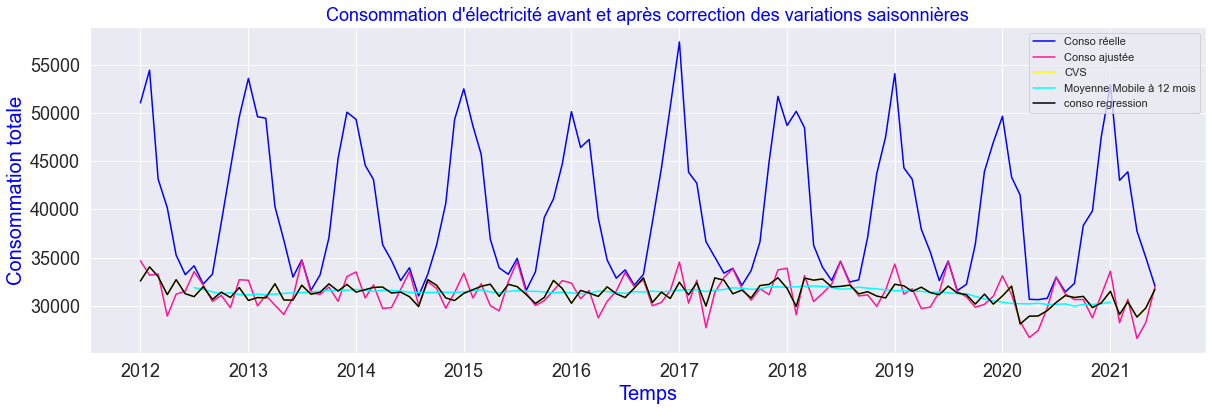

In [62]:
sns.set(style = "darkgrid")
plt.figure(figsize = (20,6))

# Variables de la figure
x1 = df_electricite_chauffage.index
y1 = df_electricite_chauffage["Conso_total_observe"]
x2 = df_electricite_chauffage.index
y2 = df_electricite_chauffage["conso_ajustee"]
x3 = df_electricite_chauffage.index
y3 = df_electricite_chauffage["cvs"]
x4 = df_electricite_chauffage.index
y4 = df_electricite_chauffage["cvs"].rolling(12, center=True).mean()
x5 = df_electricite_chauffage.index
y5 = df_electricite_chauffage["cvs"]


plt.plot(x1, y1, color = "blue", label = "Conso réelle")
plt.plot(x2, y2, color = "deeppink", label = "Conso ajustée")
plt.plot(x3, y3, color = "yellow", label = "CVS")
plt.plot(x4,y4, color = "cyan", label='Moyenne Mobile à 12 mois')
plt.plot(x5, y5, color = "black", label = "conso regression")


 
# Métadonnées
plt.title("Consommation d'électricité avant et après correction des variations saisonnières", fontsize = 18, color = "blue")
plt.ylabel("Consommation totale", fontsize = 20, color = "blue")
plt.xlabel("Temps", fontsize = 20, color = "blue")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Sauvegarder la figure 
#plt.savefig("Conso_mensuelle.png")


plt.legend()

# Mission 3

## Prévoyez une série à l’aide des méthodes de lissage exponentiel: La méthode de Holt Winters

Si on souhaite prévoir la série consommation électrique à l'aide du lissage exponentiel simple, on peut utiliser les commandes suivantes :

In [63]:
from statsmodels.tsa.api import ExponentialSmoothing

In [64]:
y = np.asarray(df_electricite_chauffage["conso_ajustee"])
holt_winter = ExponentialSmoothing(y, seasonal_periods = 12, trend = "add", seasonal = "add").fit()
 
holt_winter_pred = holt_winter.forecast(12) # On utilise ici le forecast sur 12 mois 
                                            #afin de prévoir la consommation électrique
                                           # sur cette période pour l'année avenir 



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


### Prédiction de la prévision sur 12 mois pour l'année 2022

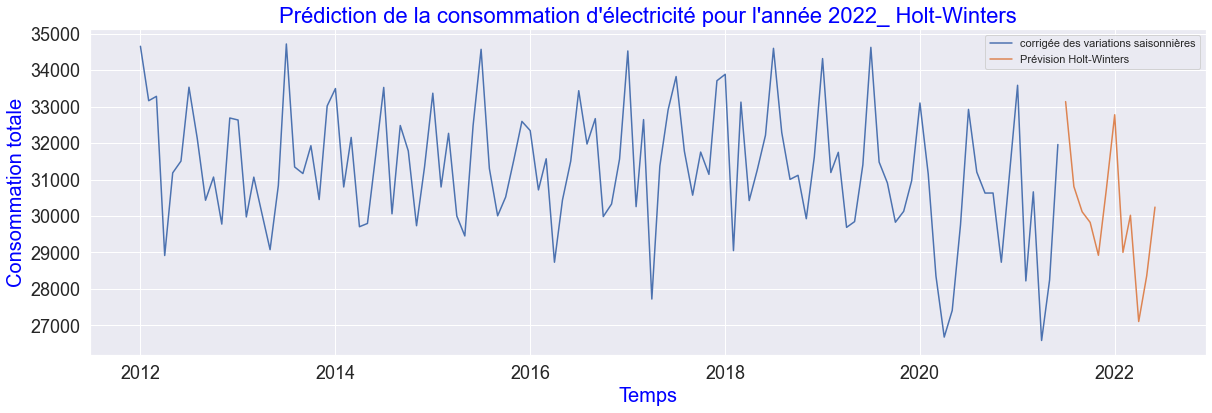

In [65]:
plt.figure(figsize = (20,6))
plt.plot(df_electricite_chauffage["conso_ajustee"], label='corrigée des variations saisonnières')
plt.plot(pd.date_range(df_electricite_chauffage.index[len(y)-1], periods=12, freq='M'),
                                          holt_winter_pred, label='Prévision Holt-Winters')

# Métadonnées
plt.title("Prédiction de la consommation d'électricité pour l'année 2022_ Holt-Winters", fontsize = 22, color = "blue")
plt.ylabel("Consommation totale", fontsize = 20, color = "blue")
plt.xlabel("Temps", fontsize = 20, color = "blue")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Sauvegarder la figure 
plt.savefig("Prévision_2022_Holt_Winters.png")

plt.legend()
plt.show()

### Analyse a posteriori

In [66]:
df_electricite_chauffage

,Conso_total_observe,Conso_ajuste_reg_lineaire,conso_ajustee,cvs
Mois,,,,
2012-01-01,51086,47736.834096,34658.561880,32560.701090
2012-02-01,54476,52621.063466,33164.332510,34027.017711
2012-03-01,43156,41180.526204,33284.869772,33019.100371
2012-04-01,40176,42569.035854,28916.360122,31141.862692
2012-05-01,35257,35382.031677,31184.364299,32695.618340
...,...,...,...,...
2021-02-01,43024,46113.646758,28219.749218,29082.434419
2021-03-01,43913,44558.907079,30663.488897,30397.719495
2021-04-01,37747,42471.253485,26585.142491,28810.645062


In [67]:
# Troncature du dataset qui va de l'année 2021 à l'année 2021
x_tronc = df_electricite_chauffage['2017':]
# l'année à prévoir 2020
x_a_prevoir = df_electricite_chauffage['2020']

<ipython-input-67-6eb14828886d>:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  x_a_prevoir = df_electricite_chauffage['2020']


In [68]:
y_x_tronc= x_tronc['conso_ajustee']
holt_winter2 = ExponentialSmoothing(y_x_tronc, seasonal_periods = 12, trend = "add", seasonal = "add").fit()
holt_winter_pred2 = holt_winter2.forecast(12)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


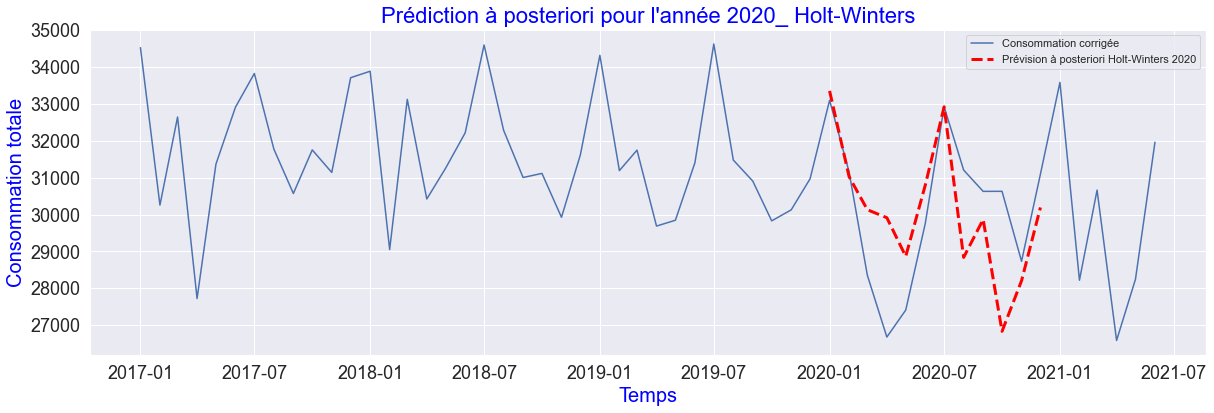

In [69]:
plt.figure(figsize = (20,6))
plt.plot(x_tronc["conso_ajustee"], label='Consommation corrigée')
plt.plot(x_a_prevoir.index, holt_winter_pred2, color = 'red', 
         label =  'Prévision à posteriori Holt-Winters 2020', linestyle = 'dashed', lw = 3)

# Métadonnées
plt.title("Prédiction à posteriori pour l'année 2020_ Holt-Winters", fontsize = 22, color = "blue")
plt.ylabel("Consommation totale", fontsize = 20, color = "blue")
plt.xlabel("Temps", fontsize = 20, color = "blue")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Sauvegarder la figure 
plt.savefig("a_posteriori_2020_Holt_Winters.png")


plt.legend()
plt.show()

 Nous allons faire une zoom sur l'année 2020

In [70]:
zoom_x_tronc = df_electricite_chauffage['2020']

<ipython-input-70-ce665ded90cd>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  zoom_x_tronc = df_electricite_chauffage['2020']


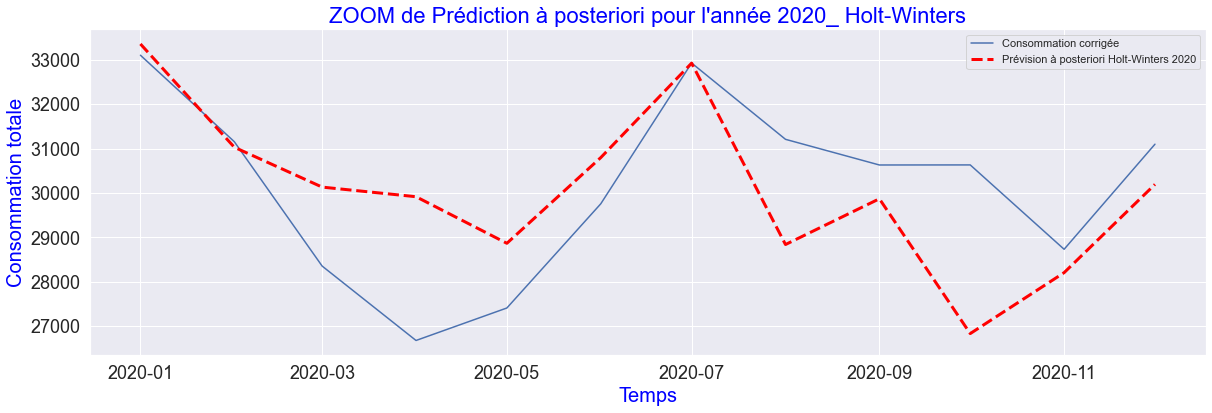

In [71]:
plt.figure(figsize = (20,6))
plt.plot(zoom_x_tronc['conso_ajustee'] , label='Consommation corrigée')
plt.plot(x_a_prevoir.index, holt_winter_pred2, color = 'red', 
         label =  'Prévision à posteriori Holt-Winters 2020', linestyle = 'dashed', lw = 3)

# Métadonnées
plt.title("ZOOM de Prédiction à posteriori pour l'année 2020_ Holt-Winters", fontsize = 22, color = "blue")
plt.ylabel("Consommation totale", fontsize = 20, color = "blue")
plt.xlabel("Temps", fontsize = 20, color = "blue")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Sauvegarder la figure 
plt.savefig("a_posteriori_2020_Holt_Winters.png")


plt.legend()
plt.show()

### Evaluation du modèle 

https://www.aspexit.com/comment-valider-un-modele-de-prediction/

#### l'Erreur quadratique moyenne (RMSE )

In [72]:
rmse = round(np.sqrt(((x_a_prevoir['conso_ajustee']-holt_winter_pred)**2).mean()),2)
rmse

1707.05

####  l'erreur relative absolue moyenne MAPE (Mean Average Percentage Error)

In [73]:
mape=(np.abs(1-holt_winter_pred/x_a_prevoir['conso_ajustee'])).mean()*100
mape

4.429423031881796

### Prévision sur 24 Mois 

In [74]:
# l'année à prévoir 2019_2020
x_tronc2 = df_electricite_chauffage['2019':'2020']


In [75]:
holt_winter2 = ExponentialSmoothing(y_x_tronc, seasonal_periods = 24, trend = "add", seasonal = "add").fit()
holt_winter_pred2 = holt_winter2.forecast(24)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


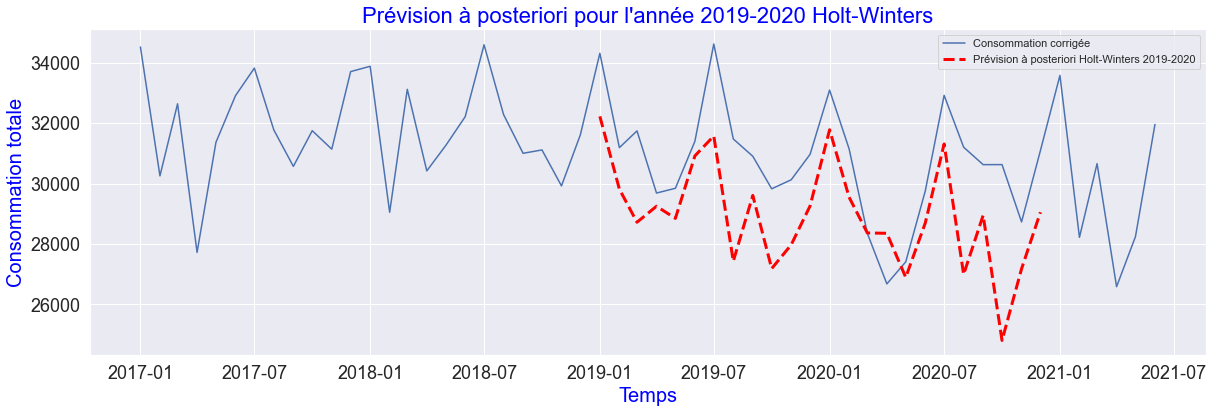

In [76]:
plt.figure(figsize = (20,6))
plt.plot(x_tronc["conso_ajustee"], label='Consommation corrigée')
plt.plot(x_tronc2.index, holt_winter_pred2, color = 'red', 
         label =  'Prévision à posteriori Holt-Winters 2019-2020', linestyle = 'dashed', lw = 3)

# Métadonnées
plt.title("Prévision à posteriori pour l'année 2019-2020 Holt-Winters", fontsize = 22, color = "blue")
plt.ylabel("Consommation totale", fontsize = 20, color = "blue")
plt.xlabel("Temps", fontsize = 20, color = "blue")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Sauvegarder la figure 
plt.savefig("a_posteriori_2020_Holt_Winters.png")


plt.legend()
plt.show()

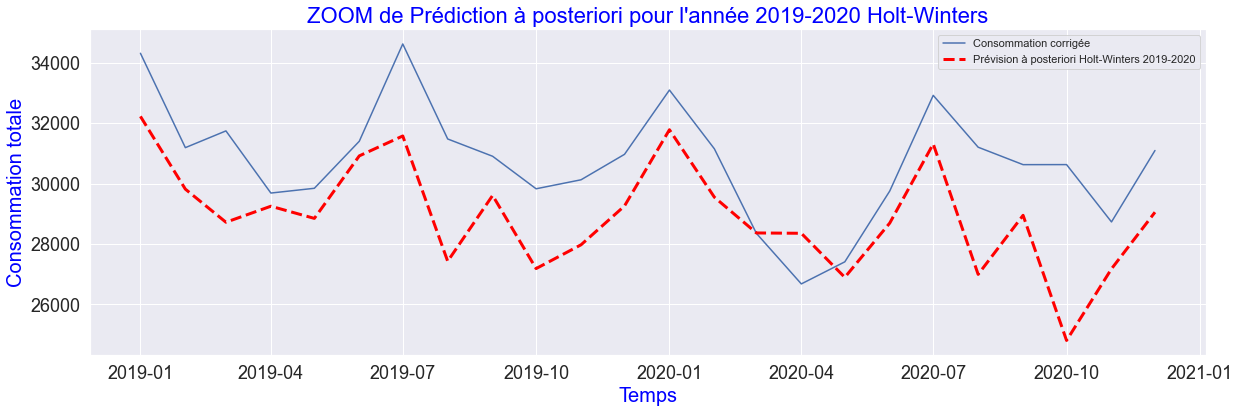

In [77]:
plt.figure(figsize = (20,6))
plt.plot(x_tronc2['conso_ajustee'] , label='Consommation corrigée')
plt.plot(x_tronc2.index, holt_winter_pred2, color = 'red', 
         label =  'Prévision à posteriori Holt-Winters 2019-2020', linestyle = 'dashed', lw = 3)

# Métadonnées
plt.title("ZOOM de Prédiction à posteriori pour l'année 2019-2020 Holt-Winters", fontsize = 22, color = "blue")
plt.ylabel("Consommation totale", fontsize = 20, color = "blue")
plt.xlabel("Temps", fontsize = 20, color = "blue")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Sauvegarder la figure 
plt.savefig("a_posteriori_2020_Holt_Winters.png")


plt.legend()
plt.show()

## Prévoyez une série temporelle à l’aide des méthodes SARIMA

In [78]:
sarima = pd.read_csv(r"C:\Users\Utilisateur\projet 9\sarima.csv", parse_dates=['Mois'])
df_sarima = sarima[["Mois", "conso_ajustee"]]
df_sarima

,Mois,conso_ajustee
0,2012-01-01,34658.561880
1,2012-02-01,33164.332510
2,2012-03-01,33284.869772
3,2012-04-01,28916.360122
4,2012-05-01,31184.364299
...,...,...
109,2021-02-01,28219.749218
110,2021-03-01,30663.488897
111,2021-04-01,26585.142491
112,2021-05-01,28245.349131


### Test si la série est stationnaire

In [79]:
from statsmodels.tsa.stattools import adfuller, acf, pacf

In [80]:
result = adfuller(df_sarima.conso_ajustee.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.704448
p-value: 0.845594


 ### Comment trouver l'ordre de différenciation (d)¶

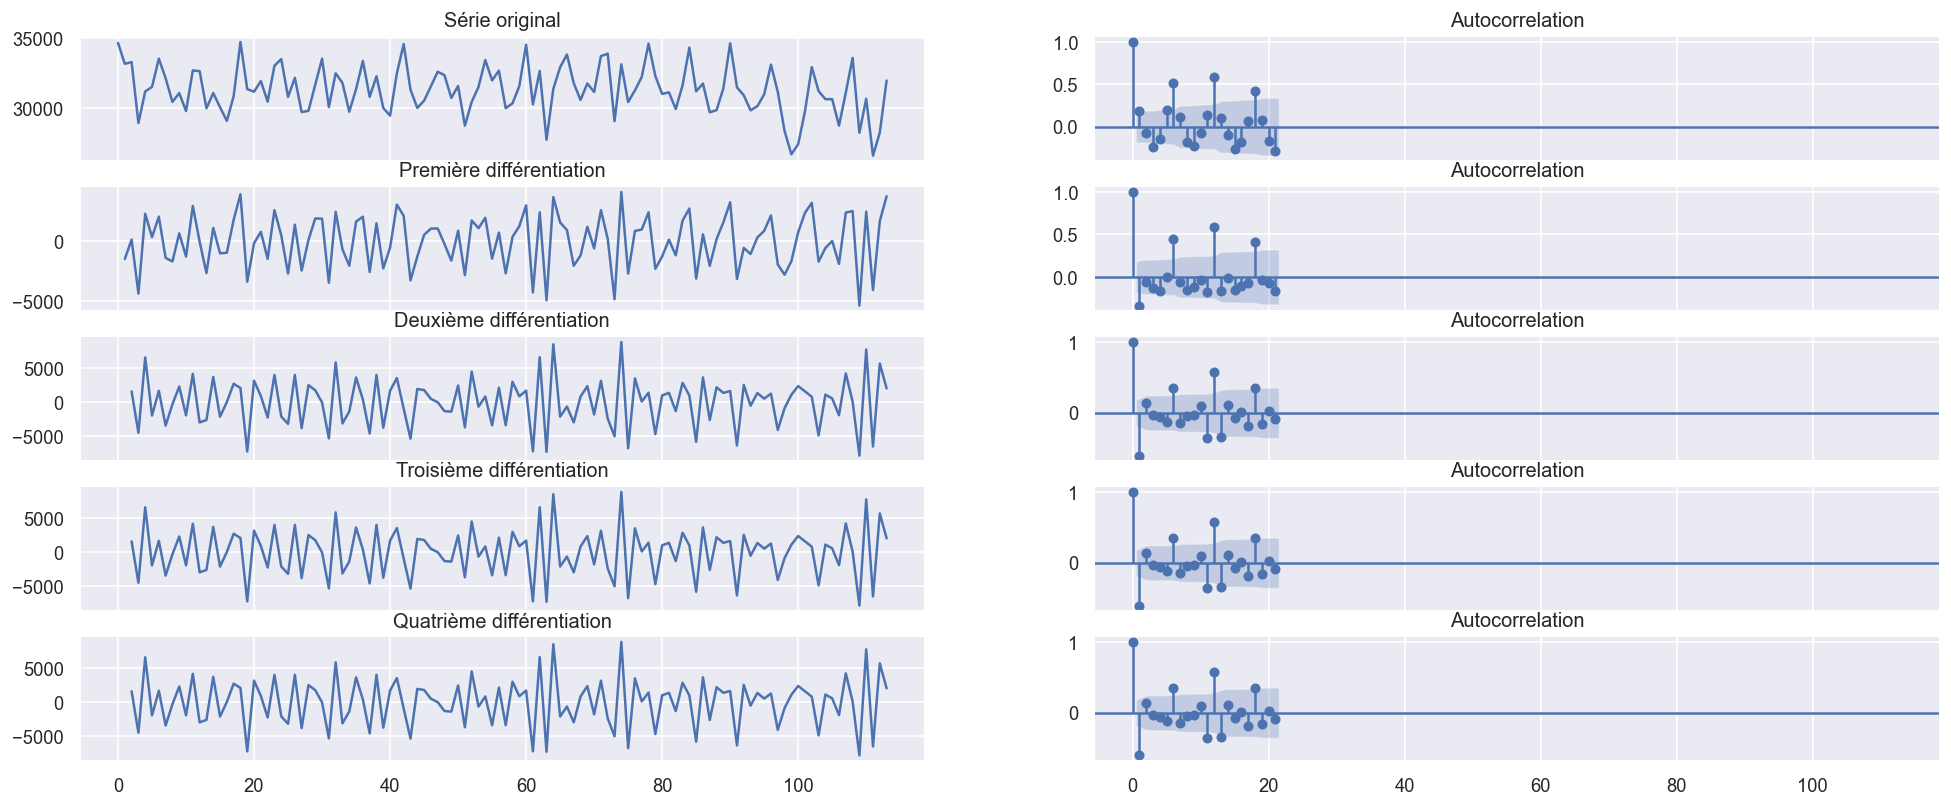

In [81]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(20,8), 'figure.dpi':120})


# Série original
fig, axes = plt.subplots(5, 2, sharex=True)
axes[0, 0].plot(df_sarima.conso_ajustee); axes[0, 0].set_title('Série original')
plot_acf(df_sarima.conso_ajustee, ax=axes[0, 1])

# Première différentiation
axes[1, 0].plot(df_sarima.conso_ajustee.diff()); axes[1, 0].set_title('Première différentiation')
plot_acf(df_sarima.conso_ajustee.diff().dropna(), ax=axes[1, 1])

# Deuxième différentiation
axes[2, 0].plot(df_sarima.conso_ajustee.diff().diff()); axes[2, 0].set_title('Deuxième différentiation')
plot_acf(df_sarima.conso_ajustee.diff().diff().dropna(), ax=axes[2, 1])

# Troisième différentiation
axes[3, 0].plot(df_sarima.conso_ajustee.diff().diff()); axes[3, 0].set_title('Troisième différentiation')
plot_acf(df_sarima.conso_ajustee.diff().diff().dropna(), ax=axes[3, 1])

# Quatrième  différentiation
axes[4, 0].plot(df_sarima.conso_ajustee.diff().diff()); axes[4, 0].set_title('Quatrième différentiation')
plot_acf(df_sarima.conso_ajustee.diff().diff().dropna(), ax=axes[4, 1])


plt.show()

### Comment trouver l'ordre du terme AR (p)

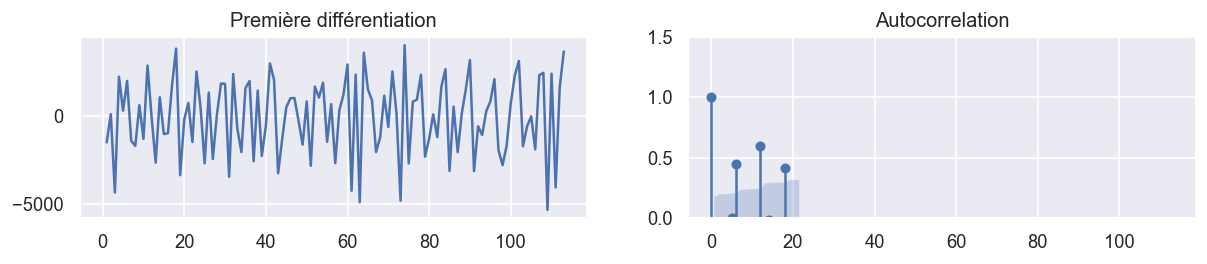

In [82]:
# PACF plot Première différentiation
plt.rcParams.update({'figure.figsize':(12,2), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_sarima.conso_ajustee.diff()); axes[0].set_title('Première différentiation')
axes[1].set(ylim=(0,1.5))
plot_acf(df_sarima.conso_ajustee.diff().dropna(), ax=axes[1])

plt.show()

### Comment trouver l'ordre du terme MA (q)¶

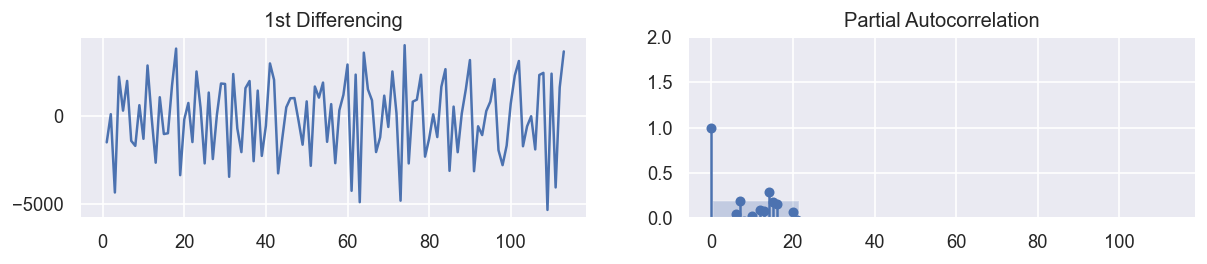

In [83]:
# ACF plot Première différentiation
plt.rcParams.update({'figure.figsize':(12,2), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_sarima.conso_ajustee.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,2))
plot_pacf(df_sarima.conso_ajustee.diff().dropna(), ax=axes[1])

plt.show()

### Construire le modèle SARIMA 

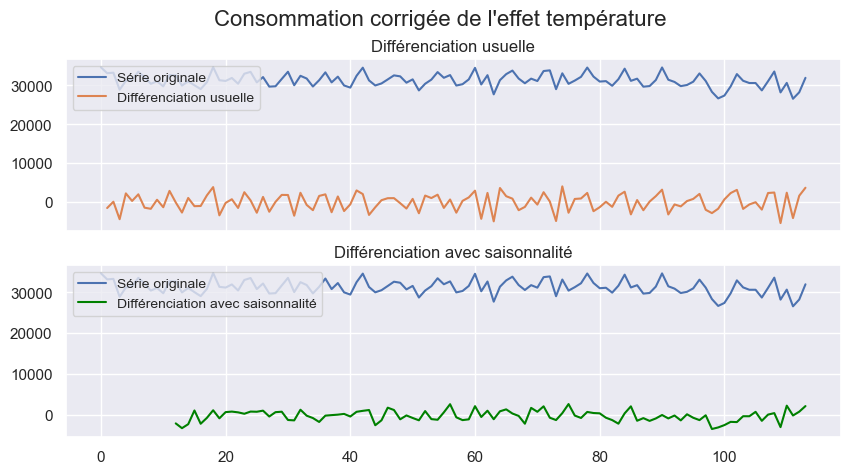

In [84]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Série différenciée une fois
axes[0].plot(df_sarima.conso_ajustee[:], label='Série originale')
axes[0].plot(df_sarima.conso_ajustee[:].diff(1), label='Différenciation usuelle')
axes[0].set_title('Différenciation usuelle')
axes[0].legend(loc='upper left', fontsize=10)


# Série différenciée douze fois
axes[1].plot(df_sarima.conso_ajustee[:], label='Série originale')
axes[1].plot(df_sarima.conso_ajustee[:].diff(12), label='Différenciation avec saisonnalité', color='green')
axes[1].set_title('Différenciation avec saisonnalité')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle("Consommation corrigée de l'effet température", fontsize=16)
plt.show()

In [85]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(df_sarima.conso_ajustee, start_p=1, start_q=1,
                         test='adf',
                         max_p=1, max_q=1, m=12,
                         start_P=1, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1765.279, Time=0.38 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1760.657, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1761.677, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1761.762, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1760.418, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1759.998, Time=0.07 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1761.904, Time=0.15 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=1761.851, Time=0.20 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1760.076, Time=0.07 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1761.744, Time=0.07 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1763.281, Time=0.17 sec
 ARIMA(0,0,0)(1,1,0)[12]             : AIC=1759.634, Time=0.03 sec
 ARIMA(0,0,0)(2,1,0)[12]             : AIC=1761.615, Time=0.07 sec
 ARIMA(0,0,0)(1,1,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                          y   No. Observations:                  114
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                -877.160
Date:                    Mon, 07 Feb 2022   AIC                           1758.320
Time:                            16:41:49   BIC                           1763.570
Sample:                                 0   HQIC                          1760.446
                                    - 114                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.0397      0.016     -2.476      0.013      -0.071      -0.008
sigma2       1.62e+06   2.38e+05      6.807      0.000    1.15e+06    2.09e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.63   Jarque-Bera (JB):                 0.89
Prob(Q):                              0.10   Prob(JB):                         0.64
Heteroskedasticity (H):               1.53   Skew:                            -0.10
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Modèle 1

On estime en premier lieu un modèle  𝑆𝐴𝑅𝐼𝑀𝐴(1,1,1)(1,1,1)12  au vu des autocorrélogrammes empiriques simples et partiels. Ce modèle s’écrit :

(𝐼−φ1𝐵)(𝐼−φ′1𝐵12)(𝐼−𝐵)(𝐼−𝐵12)𝑙𝑛(𝑋𝑡)=(𝐼+θ1𝐵)(𝐼+θ′1𝐵12)ε𝑡

In [86]:
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox
#order=(1,1,1), seasonal_order=(1,1,1,12))
model1 = SARIMAX((y), order=(1,1,1), seasonal_order=(0,1,1,12))
results1 = model1.fit()
print(results1.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results1.resid, lags=elt)[1].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  114
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -885.455
Date:                            Mon, 07 Feb 2022   AIC                           1778.910
Time:                                    16:41:49   BIC                           1789.371
Sample:                                         0   HQIC                          1783.145
                                            - 114                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4282      0.125      3.437      0.001       0.184       0.672
ma.L1         -0.6322      0.125   

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [87]:
from scipy.stats import shapiro

shapiro(results1.resid)

ShapiroResult(statistic=0.4606932997703552, pvalue=1.3094577221492604e-18)

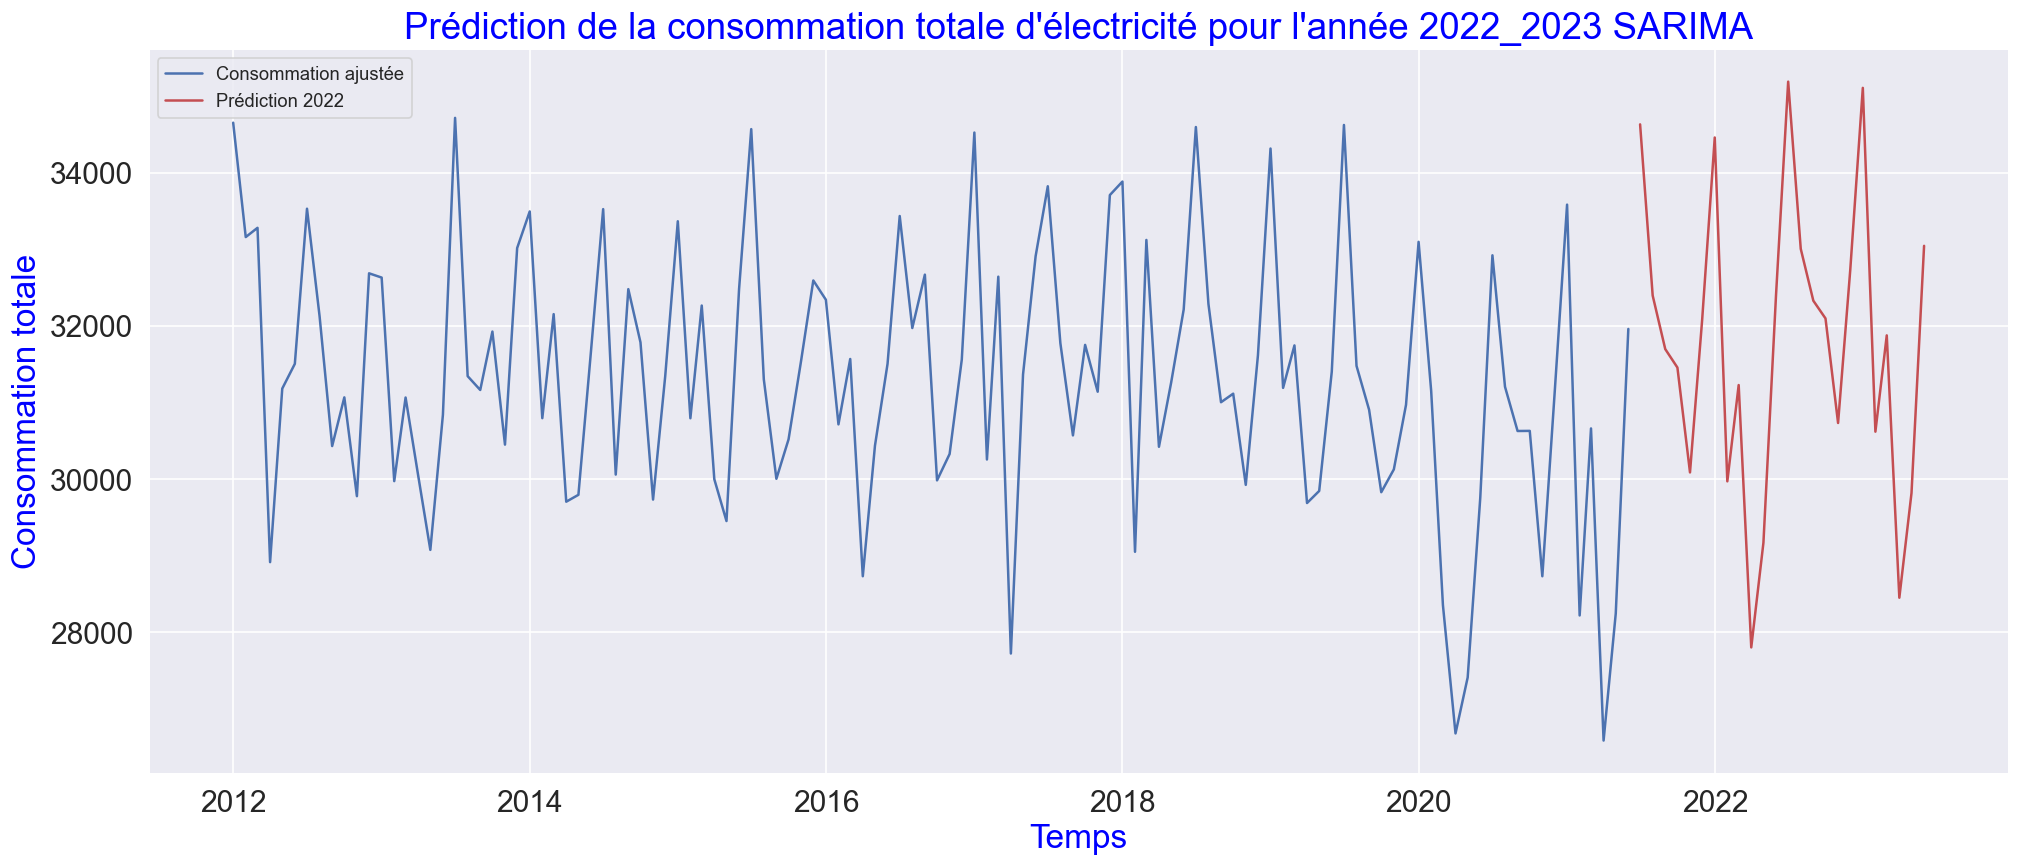

In [88]:

ysarima = df_sarima
ysarima.set_index("Mois", inplace = True)
ysarima

pred_model1 = results1.get_forecast(24)
pred = pred_model1.predicted_mean


plt.figure(figsize=(20,8))
plt.plot(ysarima, label='Consommation ajustée')
plt.plot(pd.date_range(ysarima.index[len(ysarima)-1], periods=24, freq='M'), pred, color='r', label='Prédiction 2022')

# Métadonnées
plt.title("Prédiction de la consommation totale d'électricité pour l'année 2022_2023 SARIMA", fontsize = 22, color = "blue")
plt.ylabel("Consommation totale", fontsize = 20, color = "blue")
plt.xlabel("Temps", fontsize = 20, color = "blue")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Sauvegarder la figure 
#plt.savefig("Prévision_2022_SARIMA.png")


plt.legend()
plt.show()

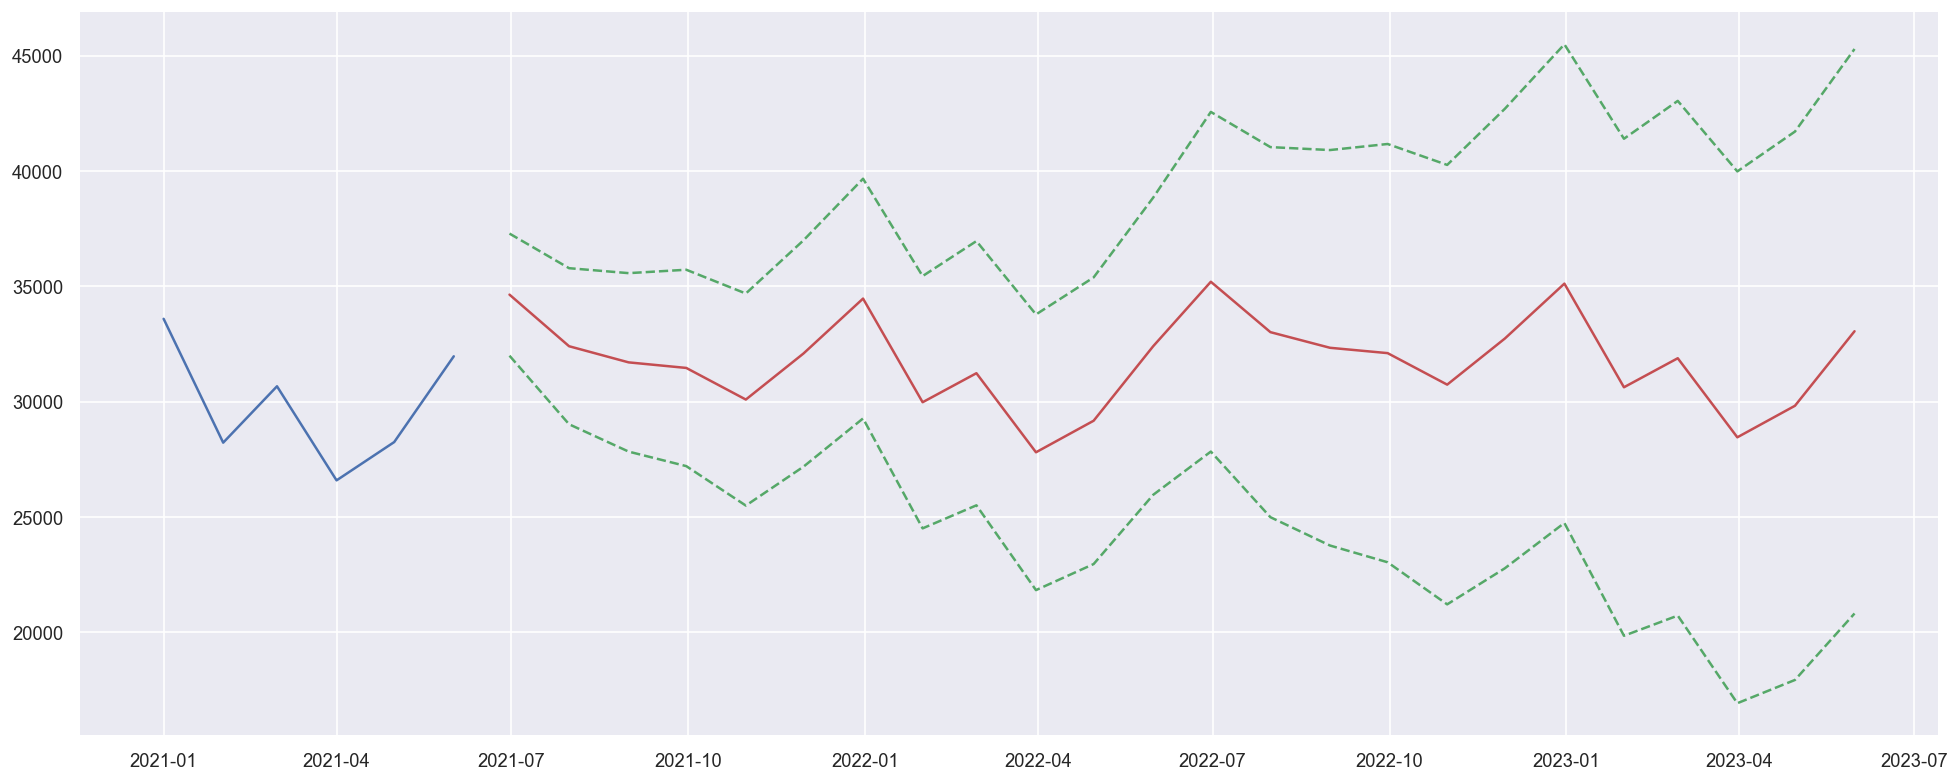

In [89]:
# Avec intervalles de confiance sur la prévision à 12 mois
pred_model = results1.get_forecast(24)
pred = pred_model.predicted_mean

pred_l = [(elt[0]) for elt in pred_model.conf_int(alpha=0.05)]
pred_u = [(elt[1]) for elt in pred_model.conf_int(alpha=0.05)]

plt.figure(figsize=(20,8))
plt.plot(df_electricite_chauffage["conso_ajustee"]['2021':]  , label='Consommation ajustée')
plt.plot(pd.date_range(df_electricite_chauffage.index[len(df_electricite_chauffage)-1], periods=24, freq='M'), pred, color='r', label='Prévision SARIMA')
plt.plot(pd.date_range(df_electricite_chauffage.index[len(df_electricite_chauffage)-1], periods=24, freq='M'), 
         pred_l, color='g', linestyle='--', label='int95%_inf')
plt.plot(pd.date_range(df_electricite_chauffage.index[len(df_electricite_chauffage)-1], periods=24, freq='M'), 
         pred_u, color='g', linestyle='--', label='int95%_sup')


plt.show() 

 #### Analyse a posteriori

In [90]:
# Troncature du dataset qui va de l'année 2021 à l'année 2021
x_tronc = ysarima['2017':]
# l'année à prévoir 2020
x_a_prevoir = x_tronc['conso_ajustee']['2020']

In [91]:
#order=(0,1,1), seasonal_order=(1,0,1,12))
model3tronc = SARIMAX(np.asarray(x_tronc['conso_ajustee']), order=(1,1,1), seasonal_order=(0,1,1,12))
results3tronc = model3tronc.fit()
print(results3tronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results3tronc.resid, lags=elt)[1].mean()))
    
shapiro(results3tronc.resid)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   54
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -360.144
Date:                            Mon, 07 Feb 2022   AIC                            728.288
Time:                                    16:41:50   BIC                            735.142
Sample:                                         0   HQIC                           730.784
                                             - 54                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4061      0.565      0.719      0.472      -0.701       1.513
ma.L1         -0.5025      0.564   

ShapiroResult(statistic=0.5008686780929565, pvalue=2.767379858256702e-12)

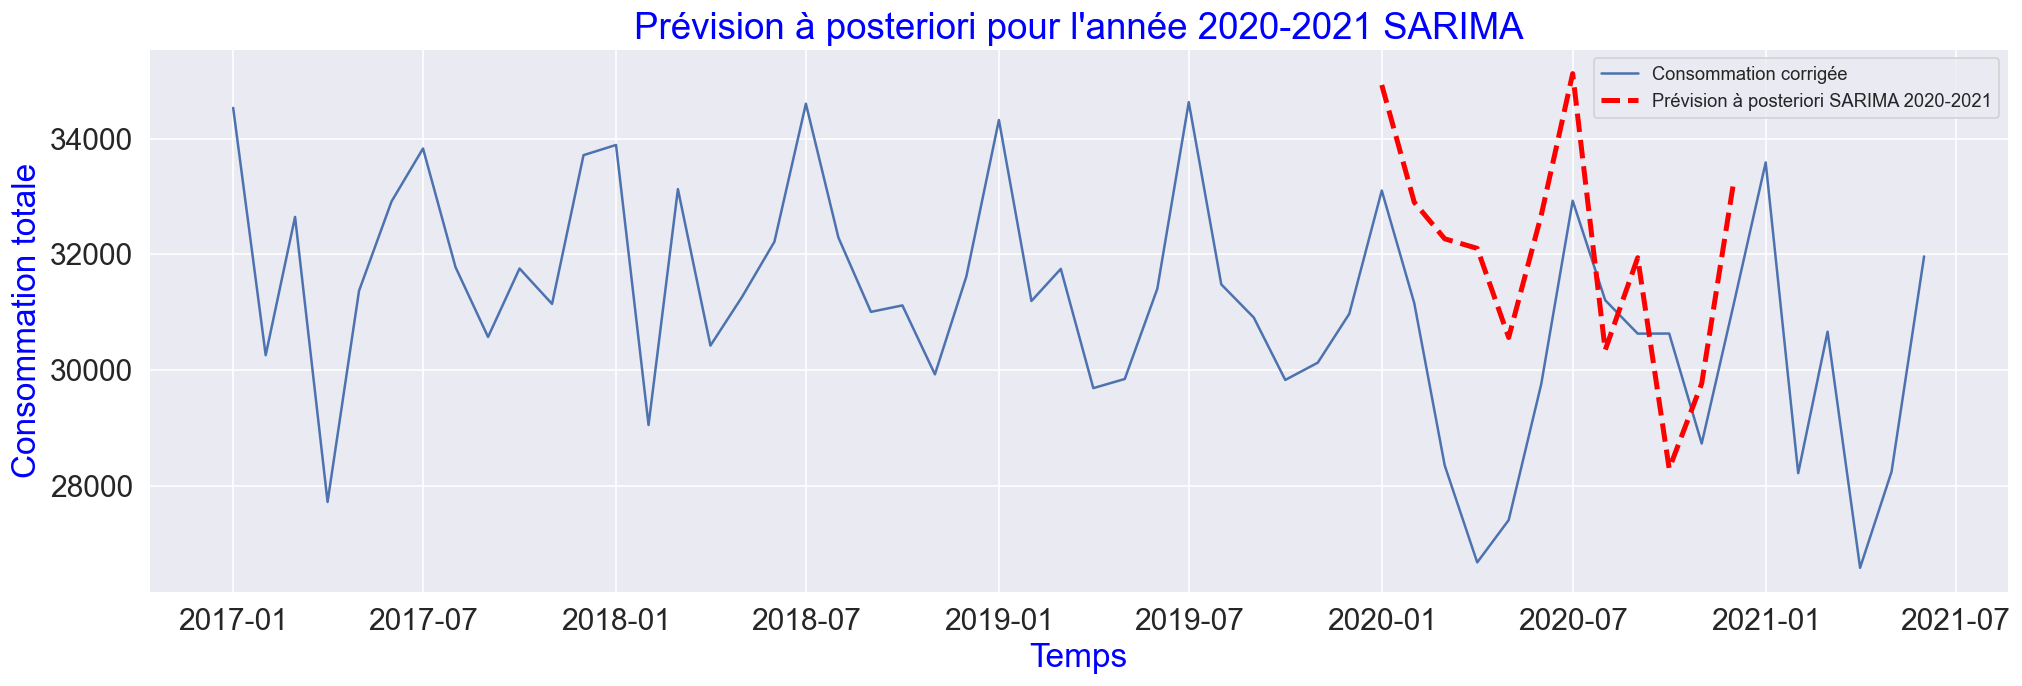

In [92]:
pred_model3tronc = results3tronc.get_forecast(12)
pred_tronc = pred_model3tronc.predicted_mean

plt.figure(figsize = (20,6))
plt.plot(x_tronc["conso_ajustee"], label='Consommation corrigée')
plt.plot(x_a_prevoir.index, pred_tronc, color = 'red', 
         label =  'Prévision à posteriori SARIMA 2020-2021', linestyle = 'dashed', lw = 3)

# Métadonnées
plt.title("Prévision à posteriori pour l'année 2020-2021 SARIMA", fontsize = 22, color = "blue")
plt.ylabel("Consommation totale", fontsize = 20, color = "blue")
plt.xlabel("Temps", fontsize = 20, color = "blue")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Sauvegarder la figure 
#plt.savefig("a_posteriori_2020_sarima.png")


plt.legend()
plt.show()

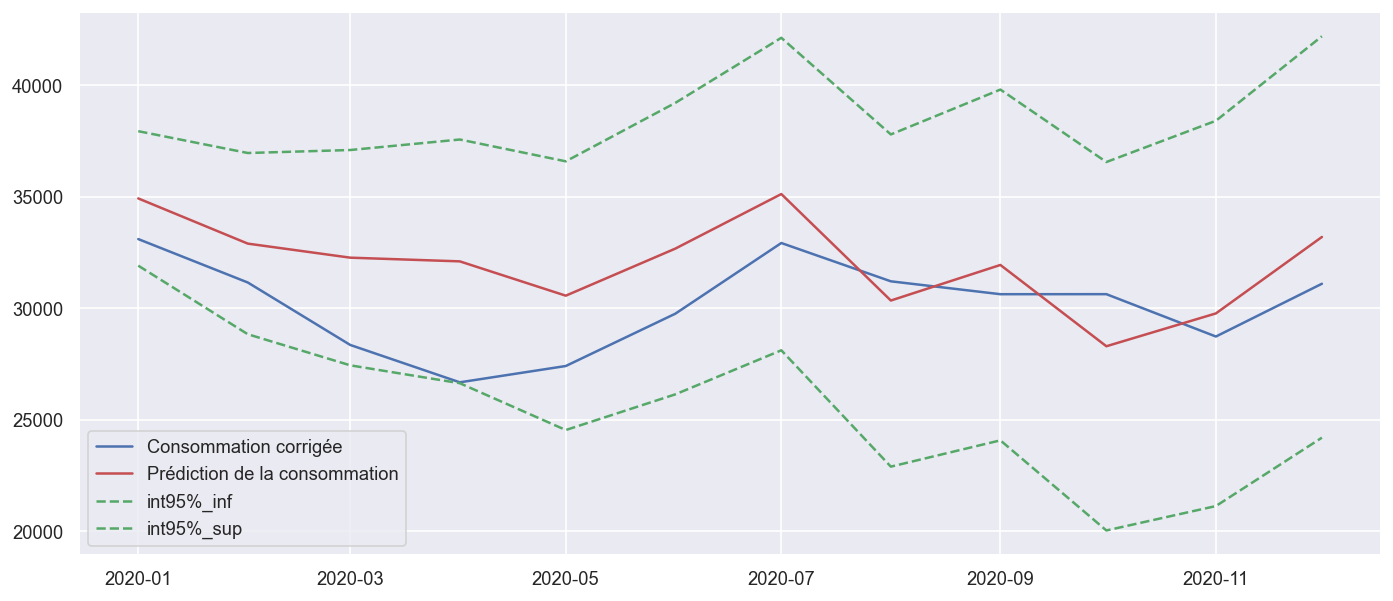

In [93]:
pred_model3tronc = results3tronc.get_forecast(12)
pred_tronc = pred_model3tronc.predicted_mean
pred_l_tronc = [(elt[0]) for elt in pred_model3tronc.conf_int(alpha=0.05)]
pred_u_tronc = [(elt[1]) for elt in pred_model3tronc.conf_int(alpha=0.05)]

plt.figure(figsize=(14,6))
plt.plot(x_a_prevoir, label='Consommation corrigée')
plt.plot(x_a_prevoir.index, pred_tronc, color='r', label='Prédiction de la consommation')
plt.plot(x_a_prevoir.index, pred_l_tronc, color='g', linestyle='--', label='int95%_inf')
plt.plot(x_a_prevoir.index, pred_u_tronc, color='g', linestyle='--', label='int95%_sup')
plt.legend()
plt.show()

In [94]:
x_a_prevoir

Mois
2020-01-01    33101.888325
2020-02-01    31154.760253
2020-03-01    28353.827741
2020-04-01    26678.257551
2020-05-01    27409.849153
2020-06-01    29755.841591
2020-07-01    32925.997934
2020-08-01    31207.989668
2020-09-01    30630.032359
2020-10-01    30631.638381
2020-11-01    28731.922795
2020-12-01    31098.448932
Name: conso_ajustee, dtype: float64

In [95]:
mape=(np.abs(1-pred_tronc/x_tronc['conso_ajustee']['2020'])).mean()*100
mape

8.187383629252977

In [96]:
#!pip3 install pyramid-arima